# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import missingno as msno
from googletrans import Translator
import Levenshtein

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.csv as pc
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# import xgboost as xgb
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import sys
# from IPython.display import display
# import pprint
# import itertools
# import math
# import nltk
# from nltk.corpus import wordnet

'''
custom modules
'''
# function similar to Excel's vlookup
from vlookup import vlookup
# function to view all contents of a dataframe
from view_all import view_all
# function for the project
from section_1 import msno_overview
from section_2 import similar_feature, attribute_cat, str_to_num, ger_to_eng, pv_min_max, \
    pv_meaning_score, pv_verify_null
from section_3 import dataset_summary, view_feature
from section_4 import miss_val_summary

In [2]:
# pip install googletrans==4.0.0-rc1
# pip install missingno
# pip install pyarrow
# custom modules for convenience are in root folder

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Load and overview

#### 1.1 azdias

In [3]:
# 제출전 주석 해제
# '''
# load and file overview
# '''

# azdias = pd.read_csv('../csv_pickle/Udacity_AZDIAS_052018.csv', sep=';')
# azdias.name = 'azdias'
#
# print (azdias.info())
# azdias.head()

In [4]:
azdias = pd.read_pickle('../csv_pickle/azdias.pickle')

print (azdias.info())
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
# '''
# missing value overview
# '''

# azdias.name = 'azdias'
# msno_overview(azdias)

#### 1.2 customers

In [6]:
# 제출전 주석 해제
# '''
# load and file overview
# '''

# customers = pd.read_csv('../csv_pickle/Udacity_CUSTOMERS_052018.csv', sep=';')
# print (customers.info())
# customers.head()

In [7]:
customers = pd.read_pickle('../csv_pickle/customers.pickle')

print (customers.info())
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
# '''
# missing value overview
# '''

# customers.name = 'customers'
# msno_overview(customers)

#### 1.3 info

In [9]:
'''
load and overview
'''

ref_info = pd.read_excel(
    'DIAS Information Levels - Attributes 2017.xlsx', header=1).iloc[:, 1:]

# fillna of Information level as values are only in the 1st rows
ref_info['Information level'] = ref_info['Information level'].fillna(method = 'ffill')

print (ref_info.info())
ref_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  312 non-null    object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB
None


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


#### 1.4 attr

In [10]:
'''
load and overview
'''

ref_attr = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=1).iloc[:, 1:]
# rename column Value to Score for easier documentation
ref_attr = ref_attr.rename(columns = {'Value' : 'Score'})

print (ref_attr.info())
ref_attr[103:108]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Score        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Score,Meaning
103,NaN,NaN,9D,Mini-Jobber
104,NaN,NaN,9E,Socking Away
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,NaN,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,NaN,NaN,12,Wealthy Households-Young Couples With Children


### 2. Baseline understanding

There are 4 files given:
* 2 dataset files - azdias & customers
* 2 reference files - info & attr:  
  - info is for information on dataset features which are in unreadable German acronyms  
  - attr is for information on dataset values which are in numbers and acronyms,  
  and has corresponding meanings  

To establish a baseline, this section aims to identify key factors in the reference files   
that can help in understanding the contents of the dataset.

#### 2.1 feature alignment

As datasets do not have information on what each column feature exactly means,  
values of reference files have to be mapped to the features.
  
feature_desc below is for this needs, and formed with 369 column features from customers. 

After merging information columns, there are 264 features from both customers and info,  
along with 105 exclusive features of customers lacking Description values.

< 2개 내용을 합침  6/7>

<!-- #### 2.2 feature alignment -->

The improved readability of feature_desc has enhanced the understanding  
of the overall structure of the datasets and the meanings of the features,  
although some translations still remain unclear.  

Since there are a few features that have similar contents, it is necessary  
to perform imputation steps to resolve collinearity and reduce dimensionality  
before proceeding with the modeling process.

The following cells provide an overview of the number of features in each file  
and illustrates the feature intersection and difference between the files.

In [11]:
feature_dict = {
    'azdias' : set(azdias.columns.unique()),
    'customers' : set(customers.columns.unique()),
    'ref_info' : set(ref_info.Attribute.dropna().unique()),
    'ref_attr' : set(ref_attr.Attribute.dropna().unique()),
    }

print ('Number of features by file')
for k, v in feature_dict.items():
    print (k, ':', len(v))

Number of features by file
azdias : 366
customers : 369
ref_info : 313
ref_attr : 314


In [12]:
# feature_dict['attr'] = set(attr.Attribute.dropna().unique())

print ('Feature intersection & difference between files')
for i in range (0, 4):
    for j in range (0, 4):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[f'{key_1}_intsec_{key_2}'] = intsec
        feature_dict[f'in_{key_1}_notin_{key_2}'] = ft_diff
        
        intsec_print = f'{key_1} & {key_2} intersection:'
        ft_diff_print = f' /  in {key_1} & not-in {key_2}:'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

Feature intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & ref_info intersection:        264  /  in azdias & not-in ref_info:      102
azdias & ref_attr intersection:        272  /  in azdias & not-in ref_attr:       94
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & ref_info intersection:     264  /  in customers & not-in ref_info:   105
customers & ref_attr intersection:     272  /  in customers & not-in ref_attr:    97
ref_info & azdias intersection:        264  /  in ref_info & not-in azdias:       49
ref_info & customers intersection:     264  /  in ref_info & not-in customers:    49
ref_info & ref_attr intersection:      300  /  in ref_info & not-in ref_attr:     13
ref_attr & azdias intersection:        272  /  in ref_attr & not-in azdias:       42
ref_attr & customers intersection:     272  /  in ref_attr & not-in customers:    42
ref_attr & ref_in

* Attribute of ref_info:너무 많은 피쳐가 reference 파일에 없음

In [13]:
info_customers_similarity = similar_feature(
    'in_ref_info_notin_customers', 'in_customers_notin_ref_info', feature_dict)
info_customers_similarity.head()

,Attribute,in_customers_notin_ref_info,distance,suffix_added
2,D19_BUCH_RZ,D19_BUCH_CD,2,0
3,D19_RATGEBER_RZ,D19_RATGEBER,3,1
4,D19_TELKO_REST_RZ,D19_TELKO_REST,3,1
5,D19_REISEN_RZ,D19_REISEN,3,1
6,D19_DROGERIEARTIKEL_RZ,D19_DROGERIEARTIKEL,3,1


In [14]:
'''
많은 경우 _RZ 서픽스에 의한 차이이므로 info를 수정한
'''
org_info = ref_info.copy()
info_customers_similarity = info_customers_similarity.query('Attribute.str.len() > 5')

ref_col = 'in_customers_notin_ref_info'
ref_info = vlookup(ref_info, info_customers_similarity, lookup_col = ref_col)
ref_info.Attribute = np.where(ref_info[ref_col].isna(), ref_info.Attribute, ref_info[ref_col])
ref_info = ref_info.drop(ref_col, axis = 1)

* Attribute of ref_attr

In [15]:
attr_customers_similarity = similar_feature(
    'in_ref_attr_notin_customers', 'in_customers_notin_ref_attr', feature_dict)
attr_customers_similarity.head()

,Attribute,in_customers_notin_ref_attr,distance,suffix_added
1,D19_LOTTO_RZ,D19_LOTTO,3,1
3,D19_BUCH_RZ,D19_BUCH_CD,2,0
4,D19_RATGEBER_RZ,D19_RATGEBER,3,1
5,D19_TELKO_REST_RZ,D19_TELKO_REST,3,1
6,D19_REISEN_RZ,D19_REISEN,3,1


In [16]:
'''
많은 경우 _RZ 서픽스에 의한 차이이므로 attr를 수정한
'''
org_attr = ref_attr.copy()
attr_customers_similarity = attr_customers_similarity.query('Attribute.str.len() > 8')

ref_col = 'in_customers_notin_ref_attr'
ref_attr = vlookup(ref_attr, attr_customers_similarity, lookup_col = ref_col)
ref_attr.Attribute = np.where(ref_attr[ref_col].isna(), ref_attr.Attribute, ref_attr[ref_col])
ref_attr = ref_attr.drop(ref_col, axis = 1)

In [17]:
feature_dict['ref_info'] = set(ref_info.Attribute.dropna().unique())
feature_dict['ref_attr'] = set(ref_attr.Attribute.dropna().unique())

print ('Feature intersection & difference between files')
for i in range (0, 4):
    for j in range (0, 4):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[f'{key_1}_intsec_{key_2}'] = intsec
        feature_dict[f'in_{key_1}_notin_{key_2}'] = ft_diff
        
        intsec_print = f'{key_1} & {key_2} intersection:'
        ft_diff_print = f' /  in {key_1} & not-in {key_2}:'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

Feature intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & ref_info intersection:        299  /  in azdias & not-in ref_info:       67
azdias & ref_attr intersection:        308  /  in azdias & not-in ref_attr:       58
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & ref_info intersection:     299  /  in customers & not-in ref_info:    70
customers & ref_attr intersection:     308  /  in customers & not-in ref_attr:    61
ref_info & azdias intersection:        299  /  in ref_info & not-in azdias:       14
ref_info & customers intersection:     299  /  in ref_info & not-in customers:    14
ref_info & ref_attr intersection:      300  /  in ref_info & not-in ref_attr:     13
ref_attr & azdias intersection:        308  /  in ref_attr & not-in azdias:        6
ref_attr & customers intersection:     308  /  in ref_attr & not-in customers:     6
ref_attr & ref_in

#### 2.2 reference file modification

<내용 수정 필요. 위 마크 업과 비교하여>
As datasets do not have information on what each column feature exactly means,  
values of reference files have to be mapped to the features.
  
feature_desc below is for this needs, and formed with 369 column features from customers. 

After merging information columns, there are 264 features from both customers and info,  
along with 105 exclusive features of customers lacking Description values.

* create feature_desc

In [18]:
'''
feature_desc with column features of customers and added information from ref_info 
'''

feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc = vlookup(feature_desc, ref_info, 'Attribute')

'''
To fill missing Descriptions, add some values from attr and create translation using googletrans.
The result is saved in the root folder due to the time-consuming code execution.
'''
# # for Attribute without Description, add 12 Description values from ref_attr
# feature_desc = vlookup(feature_desc, ref_attr, 'Attribute', 'Description', intsec = 'update')

# # add category of Attribute
# feature_desc = attribute_cat(feature_desc)

# # add translated information to Desc
# feature_desc['eng_Desc'] = np.where(
#     feature_desc.Description.isna(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.eng_Desc.fillna('')

# # column order
# feature_desc = feature_desc[[
#     'category_large', 'category_small', 'Attribute', 'Information level', 'Additional notes', 'Description', 'Desc']]

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
print(feature_desc.info())
feature_desc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category_large     369 non-null    object
 1   category_small     369 non-null    object
 2   Attribute          369 non-null    object
 3   Information level  298 non-null    object
 4   Additional notes   18 non-null     object
 5   Description        312 non-null    object
 6   Desc               369 non-null    object
dtypes: object(7)
memory usage: 23.1+ KB
None


,category_large,category_small,Attribute,Information level,Additional notes,Description,Desc
0,no_category,LNR,LNR,NaN,NaN,NaN,LNR
1,AGER,AGER,AGER_TYP,NaN,in cooperation with Kantar TNS; the informatio...,best-ager typology,best-ager typology
2,AKT,AKT,AKT_DAT_KL,NaN,NaN,NaN,Act Dat KL
3,ALTER,ALTER,ALTER_HH,Household,NaN,main age within the household,main age within the household
4,ALTER,ALTER,ALTER_KIND1,NaN,NaN,NaN,Old child1


* clean ref_attr

In [19]:
'''
change numbers in str form
'''
# 2 numbers in 1 str value
ref_attr.Score = ref_attr.Score.apply(
    lambda x: [int(i) for i in x.split(',')] if isinstance(x, str) and ',' in x else x)
ref_attr = ref_attr.explode('Score').reset_index(drop=True)
# '-1' to -1
ref_attr.Score = ref_attr.Score.apply(str_to_num)

'''
merge add-on information in some cells below Description
'''
# create attribute and description_shift with shift(-1)
ref_attr['attribute_shift'] = ref_attr.Attribute.shift(-1).fillna('')
ref_attr['description_shift'] = ref_attr.Description.shift(-1).fillna('')

# merge Description and add-on
ref_attr.Description = ref_attr.Description.mask(
    (~(ref_attr['Attribute'].isna()) & (ref_attr['attribute_shift'].isna())),
    ref_attr.Description + ' ' + ref_attr.description_shift)

# replace add-on with np.nan
ref_attr.Description = ref_attr.Description.mask(
    (ref_attr['Attribute'].isna()) & ~(ref_attr['Description'].isna()),
    np.nan)
# drop description shift
ref_attr = ref_attr.drop(['attribute_shift', 'description_shift'], axis = 1)

'''
fill blank cells with corresponding values as only 1st lines
of Attribute & Description have values
'''

ref_attr[['Attribute', 'Description']] = ref_attr[
    ['Attribute', 'Description']].fillna(method = 'ffill')

'''
keep 272 intersection features between ref_attr and datasets,
and drop exclusive features of datasets that are not useful at this step
'''

ref_attr = ref_attr[ref_attr.Attribute.isin(feature_dict['ref_attr_intsec_customers'])] # query not working

ref_attr = attribute_cat(ref_attr)
ref_attr = ref_attr[['category_large', 'category_small', 'Attribute', 'Description', 'Score', 'Meaning']]

print (f'number of Attribute: {ref_attr.Attribute.nunique()}')
ref_attr.head()

number of Attribute: 308


,category_large,category_small,Attribute,Description,Score,Meaning
0,AGER,AGER,AGER_TYP,best-ager typology,-1,unknown
1,AGER,AGER,AGER_TYP,best-ager typology,0,no classification possible
2,AGER,AGER,AGER_TYP,best-ager typology,1,passive elderly
3,AGER,AGER,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER,AGER,AGER_TYP,best-ager typology,3,experience-driven elderly


* create pre-study dataframes by value form of Score

In [20]:
'''
add delimiter column Score_form
'''

ref_attr = ref_attr.copy() # to avoid SettingWithCopyWarning
ref_attr['Score_form'] = ref_attr.Score.map(type)
ref_attr.Score_form.value_counts()

<class 'int'>    2256
<class 'str'>      53
Name: Score_form, dtype: int64

In [21]:
'''
attr_num containing Scores denoted in number
'''

attr_num = ref_attr[ref_attr.Score_form == int].copy()
print (f'number of Attribute(s): {attr_num.Attribute.nunique()}')

number of Attribute(s): 300


In [22]:
'''
attr_str containing Scores denoted in string
'''

attr_str = ref_attr[ref_attr.Score_form == str].copy()
print (f'number of Attribute(s): {attr_str.Attribute.nunique()}')

number of Attribute(s): 9


In [23]:
'''
there is 1 feature that Scores are in both numeric and string forms
'''

set(attr_num.Attribute.unique()).intersection(set(attr_str.Attribute.unique()))

{'OST_WEST_KZ'}

#### 2.3 pre-study using reference files

After identifying the dataset structure in parts 2.1 and 2.2 above,  
part 2.3 focuses on examining the dataset contents.  
In this part, various aspects such as the ranges of feature values,  
values actually meaning null, data types, and more are to be verified,  
and preliminary notes will be recorded on pre-processing requirements.

<!-- ##### 2.3.0 attr modification -->

Considering that info contains information about dataset features, attr contains  
information about dataset values and the values within the datasets can be understood  
by mapping them to the corresponding Meaning values in attr.

However, it is necessary to initially modify attr since it is not in a neat form:
* 2 numbers in 1 str value like '-1, 0' or number(s) in str like '-1'
* add-on information cell below Description value cell
* only 1st rows of Attribute & Description with values, etc.

##### 2.3.1 ref_attr Scores denoted in number

먼저 attr의 contents를 보면 대부분의 데이터는 categorical 하며, 좀 더 효과적으로 데이터의 Score를 살펴보기 위해 각 Attribute의 min/max 값을 카테고리화 해 본 결과 아래와 같이 나왔다. 

< 아래 내용은 나중에 생사 >  
From min/max categories 를 만들었으며, to be further checked are:   
* If Score -1 and 0 contain data equal to null or -inf  
* If max Score values contain data equal to null or inf
* If features with wider min/max gap are discrete or continuous

In [24]:
'''
summary of attr_num with min/max value observed
'''

attr_num_score = pv_min_max(attr_num, feature_desc)
attr_num_score.head()

number of Attribute(s): 300
['-1 to -1' '-1 to 15' '-1 to 2' '-1 to 3' '-1 to 4' '-1 to 5' '-1 to 55'
 '-1 to 6' '-1 to 7' '-1 to 8' '-1 to 9' '0 to 1' '0 to 10' '0 to 21'
 '0 to 5' '0 to 6' '0 to 7' '1 to 10' '1 to 11' '1 to 12' '1 to 40'
 '1 to 5' '1 to 6' '1 to 7' '1 to 9']


,category_large,Attribute,Description,Desc,Additional notes,min,max,min_max_cat
0,OST,OST_WEST_KZ,flag indicating the former GDR/FRG,flag indicating the former GDR/FRG,no_info,-1,-1,-1 to -1
1,PRAEGENDE,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,dominating movement in the person's youth (ava...,own typology modelled on different AZ DIAS data,-1,15,-1 to 15
2,KBA05,KBA05_ANTG4,number of >10 family houses in the cell,number of >10 family houses in the cell,no_info,-1,2,-1 to 2
3,VERS,VERS_TYP,insurance typology,insurance typology,in cooperation with TNS Infratest,-1,2,-1 to 2
4,ANREDE,ANREDE_KZ,gender,gender,no_info,-1,2,-1 to 2


* **data type of features with wider min/max Score gap**
  
attr의 scoring 체계가 주어졌거니와 max/min 차이를 보면 대부분의 데이터가 discrete 임을 알 수 있음.  
그러나 min/max gap이 10 이상이면 continuous 일 수 있으므로 살펴 보았는데 이 또한 All features that have min/max Score gap over 10 are found to be discrete

In [25]:
'''
check features that have min/max Score gap over 10
'''
# from attr_num_score above, extract Attribute values having min/max Score gap over 10
temp_over10_attribute = attr_num_score[
    (attr_num_score['max'] - attr_num_score['min']) > 10].Attribute.unique()

temp_over10 = pv_meaning_score(
    attr_num.query('Attribute in @temp_over10_attribute'), feature_desc)

number of Attribute(s): 6


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ALTER,ALTER_HH,main age within the household,main age within the household,no_info,"[unknown / no main age detectable, 01.01.1895 bis 31.12.1899, 01.01.1900 bis 31.12.1904, 01.01.1905 bis 31.12.1909, 01.01.1910 bis 31.12.1914, 01.01.1915 bis 31.12.1919, 01.01.1920 bis 31.12.1924, 01.01.1925 bis 31.12.1929, 01.01.1930 bis 31.12.1934, 01.01.1935 bis 31.12.1939, 01.01.1940 bis 31.12.1944, 01.01.1945 bis 31.12.1949, 01.01.1950 bis 31.12.1954, 01.01.1955 bis 31.12.1959, 01.01.1960 bis 31.12.1964, 01.01.1965 bis 31.12.1969, 01.01.1970 bis 31.12.1974, 01.01.1975 bis 31.12.1979, 01.01.1980 bis 31.12.1984, 01.01.1985 bis 31.12.1989, 01.01.1990 bis 31.12.1994, 01.01.1995 bis 31.12.1999]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
1,CAMEO,CAMEO_INTL_2015,CAMEO classification 2015 - international typology,CAMEO classification 2015 - international typology,no_info,"[unknown, Wealthy Households-Pre-Family Couples & Singles, Wealthy Households-Young Couples With Children, Wealthy Households-Families With School Age Children, Wealthy Households-Older Families & Mature Couples, Wealthy Households-Elders In Retirement, Prosperous Households-Pre-Family Couples & Singles, Prosperous Households-Young Couples With Children, Prosperous Households-Families With School Age Children, Prosperous Households-Older Families & Mature Couples, Prosperous Households-Elders In Retirement, Comfortable Households-Pre-Family Couples & Singles, Comfortable Households-Young Couples With Children, Comfortable Households-Families With School Age Children, Comfortable Households-Older Families & Mature Couples, Comfortable Households-Elders In Retirement, Less Affluent Households-Pre-Family Couples & Singles, Less Affluent Households-Young Couples With Children, Less Affluent Households-Families With School Age Children, Less Affluent Households-Older Families & Mature Couples, Less Affluent Households-Elders In Retirement, Poorer Households-Pre-Family Couples & Singles, Poorer Households-Young Couples With Children, Poorer Households-Families With School Age Children, Poorer Households-Older Families & Mature Couples, Poorer Households-Elders In Retirement]","[-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55]"
2,GFK,GFK_URLAUBERTYP,vacation habits,vacation habits,no_info,"[Event travelers, Family-oriented vacationists, Winter sportspeople, Culture lovers, Nature fans, Hiker, Golden ager, Homeland-connected vacationists , Package tour travelers, Connoisseurs, Active families, without vacation]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,LP,LP_LEBENSPHASE_FEIN,lifestage fine,lifestage fine,modelled on different AZ DIAS data,"[single low-income earners of younger age, single low-income earners of middle age, single average earners of younger age , single average earners of middle age, single low-income earners of advanced age, single low-income earners at retirement age , single average earners of advanced age, single average earners at retirement age, single independant persons, wealthy single homeowners, single homeowners of advanced age, single homeowners at retirement age, single top earners of higher age , low-income- and average earner-couples of younger age, low-income earner-couples of higher age, average earner-couples of higher age , independant couples, wealthy homeowner-couples of younger age , homeowner-couples of higher age, top earner-couples of higher age, single parent low-income earners, single parent average earners, single parent high-income earners, low-income earner-families, average earner-families , independant families, homeowner-families, top earner-families, low-income earners of younger age from mulitperson households, average earners of younger age from mulitperson households, low-income earners of higher age from mulitperson households, average earners of higher age from mul

* Meaning 'unknown'

In [26]:
'''
어떤 값이 unknown을 갖나?
'''

ref_attr.query('Meaning == "unknown"').Score.unique()

array([-1, 0, 9], dtype=object)

In [27]:
'''
when Score value is -1, the meaning is 100% unknown in reference file
따라서 dataset에서도 -1은 모두 null 처리가 reasonable함
'''

attr_num.query('Score < 0').Meaning.value_counts()

unknown    224
Name: Meaning, dtype: int64

In [28]:
'''
NOTE dict p_process to note points to be pre-processed
'''

p_process = {'2.3.1-minus1' : 'replace / All / {-1: np.nan}'}

In [29]:
'''
-1이 아닌 경우는 null인 경우와 아닌 경우가 혼재
따라서 위에서 정리한 Attribute의 Category 기반으로 0 이나 9인
datasets Score 중 반드시 null로 처리할 것이 있는지 파악해 본다.
'''
print (attr_num.query('Score == 0').Meaning.unique())
print (attr_num.query('Score == 9').Meaning.unique())

['no classification possible' 'unknown' 'unknown / no main age detectable'
 'no transactions known' 'no transaction known'
 'no Online-transactions within the last 12 months'
 "doesn't belong to the green avantgarde" 'classification not possible'
 'none' 'no 1-2 family homes' 'no 3-5 family homes' 'no 6-10 family homes'
 'no >10 family homes' 'external supplied hedonists '
 'no score calculated']
['uniformly distributed' '01.01.1935 bis 31.12.1939' 'urban working class'
 'activity elder than 3 years' 'activity elder than 36 months'
 '90% Online-transactions within the last 12 months' 'Inactive'
 'Package tour travelers' 'unknown' 'shared flat' 'multiperson household'
 'single independant persons'
 'average earners of younger age from mulitperson households'
 'houseowners' nan '> 700.000  inhabitants'
 '70ies - peace movement (Avantgarde, O+W)'
 'length of residence more than 10 years']


In [30]:
'''
먼저 0의 경우 Meaning == 'unknown'인 category_large는
'''

unknown_0 = attr_num.query('Score == 0 and Meaning == "unknown"').category_large.unique()
unknown_0

array(['ALTERSKATEGORIE', 'ANREDE', 'CJT', 'no_category', 'HH', 'KBA05',
       'NATIONALITAET', 'PRAEGENDE', 'RETOURTYP', 'TITEL', 'WOHNDAUER',
       'W'], dtype=object)

In [31]:
'''
there category_large에서는 Score 0이더라도 Meaning != "unknown"이 발견되므로
Score 0 이라 해도 일괄적으로 null을 적용할 수는 없음
'''

attr_num.query(
    'category_large in (@unknown_0) and Score == 0 and Meaning != "unknown"').head()

,category_large,category_small,Attribute,Description,Score,Meaning,Score_form
773,KBA05,KBA05,KBA05_ALTER1,share of car owners less than 31 years old,0,none,<class 'int'>
794,KBA05,KBA05,KBA05_ALTER4,share of cars owners elder than 61 years,0,none,<class 'int'>
802,KBA05,KBA05,KBA05_ANHANG,share of trailers in the microcell,0,none,<class 'int'>
807,KBA05,KBA05,KBA05_ANTG1,number of 1-2 family houses in the cell,0,no 1-2 family homes,<class 'int'>
813,KBA05,KBA05,KBA05_ANTG2,number of 3-5 family houses in the cell,0,no 3-5 family homes,<class 'int'>


In [32]:
'''
0의 경우 Meaning == 'unknown'인 category_small은
'''

unknown_9 = attr_num.query('Score == 9 and Meaning == "unknown"').category_small.unique()
unknown_9

array(['KBA05', 'RELAT', 'SEMIO', 'ZABEOTYP'], dtype=object)

In [33]:
'''
there category_small에서는 Score 9이면 100% Meaning == "unknown"이므로
동 category의 Score 9는 모두 null 처리함
'''

attr_num.query('category_small in (@unknown_9) and Score == 9 and Meaning != "unknown"')

,category_large,category_small,Attribute,Description,Score,Meaning,Score_form


In [34]:
'''
NOTE pre-processing items
'''

p_process['2.3.1-unknown_9'] = 'mask / category_small in unknown_9 / Score 9 to -1'

* 언노운 외의 null에 상응하는 value는 없는가?

In [35]:
'''
최소값 -1은 모두 null이며, 최소값 0 또는 1일 경우

아래 내용은 나중에 생사
when Score value is 0, it means none in most cases,
and there are also some corresponding Meaning values
that seem to be definitely equal to null
'''

# 최소값 0 Meaning 점검
temp_min_0 = attr_num_score[attr_num_score['min'] == 0].Attribute
print (attr_num.query('Attribute in (@temp_min_0) and Score == 0').Meaning.unique())

# 최소값 -1 Meaning 점검
temp_min_1 = attr_num_score[attr_num_score['min'] == 1].Attribute
print (attr_num.query('Attribute in (@temp_min_1) and Score == 1').Meaning.unique())

['unknown / no main age detectable' 'unknown' 'no transactions known'
 'no transaction known' 'no Online-transactions within the last 12 months'
 "doesn't belong to the green avantgarde" 'none']
['highest activity within the last 12 months' 'Universal' 'business cell'
 'Event travelers'
 'building is located in a 125 x 125m-grid cell (RA1), which is a consumption cell'
 'single ' 'single low-income earners of younger age'
 'single low-income- and average earners of younger age '
 'typical low-income earners' 'low-income earners' 'very high mobility'
 'mainly 1-2 family homes']


In [36]:
'''
먼저 확실하게 null을 의미하는 2개 Score는 to_null 리스트에 넣어 later, pre-processing에 사용하고, 
context에 따라 정확한 의미 파악이 필요한 나머지 값들은 maybe_null에 넣어 상세 점검을 함
'''
to_null = ['unknown', 'unknown / no main age detectable']
maybe_null = ['no transaction known', 'no transactions known', 'none']

'''
메이비널 값을 컨텍스트 속에서 살펴보면
- maybe_null은 은 null이 아니며 0을 의미함
'''
for i in maybe_null:
    print (i)
    verify_maybe_null = pv_verify_null(attr_num, feature_desc, i)

no transaction known
number of Attribute(s): 34


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,D19,D19_BANKEN_DIREKT,transactional activity based on the product group DIRECT BANKS,transactional activity based on the product group DIRECT BANKS,"AZ has access to approx. 650 Million transaction data - this is the basis for the criteria family DHT4A aka. D19. This data contains unique data regarding the mail-order activity of consumers, differentiated","[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
1,D19,D19_BANKEN_GROSS,transactional activity based on the product group BIG BANKS,transactional activity based on the product group BIG BANKS,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
2,D19,D19_BANKEN_LOKAL,transactional activity based on the product group LOCAL BANKS,transactional activity based on the product group LOCAL BANKS,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
3,D19,D19_BANKEN_REST,transactional activity based on the product group FURTHER BANKS,transactional activity based on the product group FURTHER BANKS,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
4,D19,D19_BEKLEIDUNG_GEH,transactional activity based on the product group LUXURY CLOTHING,transactional activity based on the product group LUXURY CLOTHING,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"


no transactions known
number of Attribute(s): 22


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,D19,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,transaction activity BANKS in the last 12 months,no_info,"[no transactions known, very low activity, low activity, slightly increased activity, increased activity, high activity, very high activity]","[0, 1, 2, 3, 4, 5, 6]"
1,D19,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,transaction activity BANKS in the last 24 months,no_info,"[no transactions known, very low activity, low activity, slightly increased activity, increased activity, high activity, very high activity]","[0, 1, 2, 3, 4, 5, 6]"
2,D19,D19_BANKEN_DATUM,actuality of the last transaction for the segment banks TOTAL,actuality of the last transaction for the segment banks TOTAL,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 1 year, activity elder than 1,5 years, activity elder than 2 years, activity elder than 3 years, no transactions known]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
3,D19,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segment banks OFFLINE,actuality of the last transaction for the segment banks OFFLINE,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 12 months, activity elder than 18 months, activity elder than 24 months, activity elder than 36 months, no transactions known]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
4,D19,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segment banks ONLINE,actuality of the last transaction for the segment banks ONLINE,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 12 months, activity elder than 18 months, activity elder than 24 months, activity elder than 36 months, no transactions known]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"


none
number of Attribute(s): 138


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,KBA05,KBA05_ALTER1,share of car owners less than 31 years old,share of car owners less than 31 years old,no_info,"[unknown, unknown, none, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4]"
1,KBA05,KBA05_ALTER4,share of cars owners elder than 61 years,share of cars owners elder than 61 years,no_info,"[unknown, unknown, none, very low, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4, 5]"
2,KBA05,KBA05_ANHANG,share of trailers in the microcell,share of trailers in the microcell,no_info,"[unknown, unknown, none, some, some more, very many]","[-1, 9, 0, 1, 2, 3]"
3,KBA05,KBA05_CCM4,share of cars with more than 2499ccm,share of cars with more than 2499ccm,no_info,"[unknown, unknown, none, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4]"
4,KBA05,KBA05_DIESEL,share of cars with Diesel-engine in the microcell,share of cars with Diesel-engine in the microcell,no_info,"[unknown, unknown, none, very low, low, average, high]","[-1, 9, 0, 1, 2, 3, 4]"


In [37]:
'''
NOTE pre-processing items
'''

p_process['2.3.1-1'] = 'mask / All / replace Score to null if corresponding Meaning is in to_null'

##### 2.3.2 ref_attr Scores denoted in string

///// 98 features in str type are analyzed

In [38]:
'''
summary of attr_str with Meaning and Score values
'''

attr_str_score = pv_meaning_score(attr_str, feature_desc, display = False)
view_all(attr_str_score)

number of Attribute(s): 9


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ANZ,ANZ_HAUSHALTE_AKTIV,number of households in the building,number of households in the building,no_info,[numeric value (typically coded from 1-10)],[…]
1,ANZ,ANZ_HH_TITEL,number of academic title holder in building,number of academic title holder in building,no_info,[numeric value (typically coded from 1-10)],[…]
2,ANZ,ANZ_PERSONEN,number of adult persons in the household,number of adult persons in the household,no_info,[numeric value (typically coded from 1-3)],[…]
3,ANZ,ANZ_TITEL,number of professional title holder in household,number of professional title holder in household,no_info,[numeric value (typically coded from 1-10)],[…]
4,CAMEO,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,CAMEO classification 2015 - detailled classification,no_info,"[Work-Life-Balance, Wealthy Best Ager, Successful Songwriter, Old Nobility, City Nobility, Cottage Chic, Noble Jogger, Established gourmet, Fine Management, Career & Family, Powershopping Families, Rural Neighborhood, Secure Retirement, Family Starter, Family Life, String Trimmer, Empty Nest, Golden Ager, Younger Employees, Suddenly Family, Family First, Stock Market Junkies, Coffee Rider, Active Retirement, Jobstarter, Petty Bourgeois, Long-established, Sportgardener, Urban Parents, Frugal Aging, Journeymen, Mantaplatte, Factory Worker, Rear Window, Interested Retirees, Multi-culteral, Young & Mobile, Prefab, Town Seniors, First Shared Apartment, Temporary Workers, Afternoon Talk Show, Mini-Jobber, Socking Away]","[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3C, 3D, 4A, 4B, 4C, 4D, 4E, 5A, 5B, 5C, 5D, 5E, 5F, 6A, 6B, 6C, 6D, 6E, 6F, 7A, 7B, 7C, 7D, 7E, 8A, 8B, 8C, 8D, 9A, 9B, 9C, 9D, 9E]"
5,KBA13,KBA13_ANZAHL_PKW,number of cars in the PLZ8,number of cars in the PLZ8,no_info,[numeric value],[…]
6,MIN,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,year the building was first mentioned in our database,no_info,[numeric value],[…]
7,OST,OST_WEST_KZ,flag indicating the former GDR/FRG,flag indicating the former GDR/FRG,no_info,"[East (GDR), West (FRG)]","[O, W]"
8,no_category,GEBURTSJAHR,year of birth,year of birth,no_info,[numeric value],[…]


* **7 features are found as continuous.**  
  These features will checked in detail in the next section.

In [39]:
# create list of possibly containing continuous features 
pre_study_continuous = list(
    attr_str_score[attr_str_score.Score.apply(lambda x: x == ['…'])].Attribute.unique())

### 3. Dataset exploration

Based on baseline understanding and frame works from reference files in section_2,  
section_3 is dealing with actual datasets.  
In this section, steps taken in the previous section will be repeated to fine-tune  
and finalize pro-processing items.

In [40]:
'''
create a concatenated dataframe of 2 datasets for temporary use
'''

concat_data = pd.concat([customers, azdias], axis=0).reset_index(drop = True)
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082873 entries, 0 to 1082872
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(93), object(8)
memory usage: 3.0+ GB


In [41]:
'''
datasets containing intersection features in both of datasets and ref_attr
'''

datasets = concat_data[
    list(feature_dict['customers_intsec_ref_attr'])].copy()
datasets.shape

(1082873, 308)

In [42]:
'''
datasets_excl containing exclusive features of datasets
'''

datasets_excl = concat_data[
    list(feature_dict['in_customers_notin_ref_attr'])].copy()
datasets_excl.shape

(1082873, 61)

#### 3.1 intersection features in both of datasets and ref_attr

##### 3.1.1 numeric dataset Scores of intersection features

In [43]:
'''
datasets_num_score containing summary of numeric Score values
'''

datasets_num_score = dataset_summary(datasets, feature_desc, ['int', 'float'])

number of Attribute(s): 304


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
0,D19_SONSTIGE,1082873.0,2.525860,2.885597,0.0,0.0,0.0,6.0,7.0,transactional activity based on the product group ALL OTHER CATEGORIES,0.000000,0 to 7
1,KBA05_MOD1,893569.0,1.474384,1.609973,0.0,0.0,1.0,2.0,9.0,share of upper class cars (in an AZ specific definition),0.174816,0 to 9
2,GFK_URLAUBERTYP,1074806.0,7.166558,3.444051,1.0,5.0,8.0,10.0,12.0,vacation habits,0.007450,1 to 12
3,KBA13_SEG_GROSSRAUMVANS,925792.0,3.111533,1.009290,1.0,3.0,3.0,4.0,5.0,share of big sized vans within the PLZ8,0.145059,1 to 5
4,KBA13_CCM_0_1400,925792.0,2.309565,1.439908,0.0,1.0,3.0,3.0,5.0,share of cars with less than 1400ccm within the PLZ8,0.145059,0 to 5


min_max Scores: 
 ['0 to 7' '0 to 9' '1 to 12' '1 to 5' '0 to 5' '1 to 6' '1 to 9' '1 to 10'
 '0 to 15' '1 to 7' '0 to 12' '1 to 4' '0 to 6' '0 to 3' '1 to 8' '0 to 4'
 '0 to 2' '-1 to 2' '0 to 23' '0 to 10' '1 to 3' '0 to 45' '0 to 1'
 '0 to 40' '-1 to 3' '0 to 8' '1 to 2' '1_985 to 2_016' '0 to 2_017'
 '0 to 11' '0 to 21' '0 to 2_300' '0 to 595']


In [44]:
'''
check if Scores in actual datasets are within range given by ref_attr.
'''

# merge min/max values by Attribute in attr_num_score in 2.3.1
temp_range_check = vlookup(
    datasets_num_score, attr_num_score, 'Attribute', ['min', 'max', 'min_max_cat'], intsec = 'copy')

temp_range_check['check'] = np.where(
    temp_range_check['min_max_cat_'].isnull(), 
    'not in attr_num',
    np.where(
        (temp_range_check['min'] < temp_range_check['min_']),
         'min lower',
         np.where((temp_range_check['max'] > temp_range_check['max_']),
         'max higher',
         'within min/max range')))

temp_range_check.check.value_counts()

within min/max range    293
not in attr_num           7
min lower                 4
Name: check, dtype: int64

* features out of Score range of ref_attr  

293 피쳐는 pre_study에서 살펴본 Range 안에 Score가 위치하므로 Section2에서 정리한 pre-processing을 진행하면 됨

레인지를 벗어난 피쳐에 대해서는 아래에서 살펴보고 처리방안을 정리함. 또한 피쳐 이름에서 데이터 유사성이 발견되어 유사 데이터는 드롭하기로 함.

In [45]:
'''
4 features are showing lower min value in dataset 
'''
temp_range_check.query('check == "min lower"')

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat,min_,max_,min_max_cat_,check
22,LP_LEBENSPHASE_GROB,1074806.0,4.623523,4.037057,0.0,1.0,3.0,8.0,12.0,lifestage rough,0.00745,0 to 12,1.0,12.0,1 to 12,min lower
181,LP_LEBENSPHASE_FEIN,1074806.0,15.246603,13.138044,0.0,4.0,12.0,28.0,40.0,lifestage fine,0.00745,0 to 40,1.0,40.0,1 to 40,min lower
219,LP_FAMILIE_GROB,1074806.0,2.215609,1.812993,0.0,1.0,1.0,4.0,5.0,familytyp rough,0.00745,0 to 5,1.0,11.0,1 to 11,min lower
249,LP_FAMILIE_FEIN,1074806.0,3.714389,4.039212,0.0,1.0,1.0,8.0,11.0,familytyp fine,0.00745,0 to 11,1.0,11.0,1 to 11,min lower


In [46]:
'''
these 4 features of datasets have 0 as min Score.
as Meaning values of these 4 features in ref_attr do not cover null value,
Score 0 should be replaced as null (see example below)
'''

ref_attr.query('Attribute == "LP_LEBENSPHASE_GROB"').Meaning.unique()

array(['single low-income- and average earners of younger age ',
       'single low-income- and average earners of higher age ',
       'single high-income earners',
       'single low-income- and average earner-couples ',
       'single high-income earner-couples', 'single parents',
       'single low-income- and average earner-families',
       'high-income earner-families',
       'average earners of younger age from mulitperson households',
       'low-income- and average earners of higher age from mulitperson households',
       'high-income earners of younger age from multiperson households',
       'high-income earners of higher age from multiperson households'],
      dtype=object)

In [47]:
'''
NOTE pre-processing items
'''

for i in temp_range_check.query('check == "min lower"').Attribute.unique():
    p_process['3.1.1-'+ i] = 'replace / ' + i + ' / {0: -1}'

In [48]:
'''
위 피쳐의 이름을 보면 gross와 fine으로 나뉘어 있으며, 같은 피쳐에 그로스/파인이 들어 있는 항목은
유사피쳐를 크게 나누느냐 작게 나누느냐의 차이임
'''
ref_attr.query('Attribute.str.contains("LP_FAMILIE")')
# attribute_without_meaning[attribute_without_meaning.Score > 8]

,category_large,category_small,Attribute,Description,Score,Meaning,Score_form
1960,LP,LP,LP_FAMILIE_FEIN,familytyp fine,1,single,<class 'int'>
1961,LP,LP,LP_FAMILIE_FEIN,familytyp fine,2,couple,<class 'int'>
1962,LP,LP,LP_FAMILIE_FEIN,familytyp fine,3,young single parent,<class 'int'>
1963,LP,LP,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager,<class 'int'>
1964,LP,LP,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age,<class 'int'>
1965,LP,LP,LP_FAMILIE_FEIN,familytyp fine,6,young family,<class 'int'>
1966,LP,LP,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager,<class 'int'>
1967,LP,LP,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age,<class 'int'>
1968,LP,LP,LP_FAMILIE_FEIN,familytyp fine,9,shared flat,<class 'int'>
1969,LP,LP,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household,<class 'int'>


In [49]:
'''
유사한 gross와 fine이 있는 피쳐는
'''
suffix_gross_fine = ['GROB', 'FEIN']
features_gross_fine = feature_desc[
    feature_desc.Attribute.str.split('_').str[-1].isin(suffix_gross_fine)]
features_gross_fine = list(features_gross_fine.Attribute.unique())
features_gross_fine

['ALTERSKATEGORIE_FEIN',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'ALTERSKATEGORIE_GROB']

In [50]:
'''
유사한 gross가 있는 피쳐만 list로 정리하여 drop 함
'''

to_drop = feature_desc.query('Attribute.str.contains("GROB")')
to_drop = list(to_drop.Attribute.unique())

'''
NOTE pre-processing items
'''

p_process['2.3.1-drop'] = 'drop / All / drop features in to_drop'

* continuous features:   
  뭐뭐뭐

In [51]:
'''
7 features are continuous:
in ref_attr, Score values of these continuous features have string form (see 2.3.2) 
'''
continuous_in_datasets = temp_range_check.query('check == "not in attr_num"')
print (set(continuous_in_datasets.Attribute.unique()) == set(pre_study_continuous))
continuous_in_datasets

True


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat,min_,max_,min_max_cat_,check
101,ANZ_HH_TITEL,933755.0,0.044647,0.365891,0.0,0.0,0.0,0.0,23.0,number of academic title holder in building,0.137706,0 to 23,NaN,NaN,NaN,not in attr_num
125,ANZ_PERSONEN,962778.0,1.809025,1.209710,0.0,1.0,1.0,2.0,45.0,number of adult persons in the household,0.110904,0 to 45,NaN,NaN,NaN,not in attr_num
128,ANZ_TITEL,962778.0,0.006607,0.086903,0.0,0.0,0.0,0.0,6.0,number of professional title holder in household,0.110904,0 to 6,NaN,NaN,NaN,not in attr_num
234,MIN_GEBAEUDEJAHR,939798.0,1993.243781,3.296842,1985.0,1992.0,1992.0,1993.0,2016.0,year the building was first mentioned in our d...,0.132125,1_985 to 2_016,NaN,NaN,NaN,not in attr_num
236,GEBURTSJAHR,1082873.0,1083.871938,976.933275,0.0,0.0,1939.0,1967.0,2017.0,year of birth,0.000000,0 to 2_017,NaN,NaN,NaN,not in attr_num
279,KBA13_ANZAHL_PKW,925792.0,626.908028,340.528955,0.0,390.0,556.0,786.0,2300.0,number of cars in the PLZ8,0.145059,0 to 2_300,NaN,NaN,NaN,not in attr_num
293,ANZ_HAUSHALTE_AKTIV,939798.0,7.786384,15.482165,0.0,1.0,3.0,9.0,595.0,number of households in the building,0.132125,0 to 595,NaN,NaN,NaN,not in attr_num


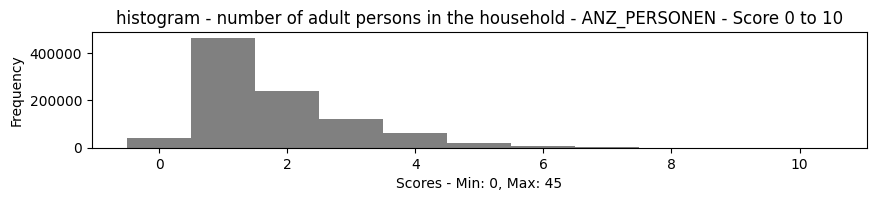

10 outliers (Score: %) 
 45: 0.0%, 40: 0.0%, 38: 0.0%, 37: 0.0%, 35: 0.0% … 8: 0.1%, 7: 0.2%, 6: 0.7%, 5: 2.3%, 4: 6.6%




In [52]:
'''
ANZ_PERSONEN  
- Value 0 might be strange or extreme but is possible
- outliers: household with over 10 adult persons is highly extreme or data error,
  that Value over 10 should be replaced to NaN
'''

view_feature (datasets, feature_desc, 'ANZ_PERSONEN', False)

In [53]:
'''
NOTE
'''

p_process['3.1.1-ANZ_PERSONEN'] = 'np.where / ANZ_PERSONEN / Score > 10 to -1'

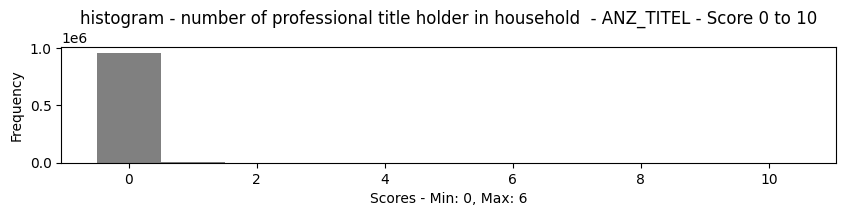

10 outliers (Score: %) 
 6: 0.0%, 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0% … 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0%, 1: 0.6%




In [54]:
'''
ANZ_TITEL
- it seems that there is no pre-processing needed.
  However, this feature is linked to ANZ_PERSONEN above
  that Score should be replaced to null if corresponding ANZ_PERSONEN is null.
'''

view_feature (datasets, feature_desc, 'ANZ_TITEL', False)

In [55]:
p_process['3.1.1-ANZ_TITEL'] = 'np.where / ANZ_TITEL / Score of ANZ_PERSONEN > 10 to -1'

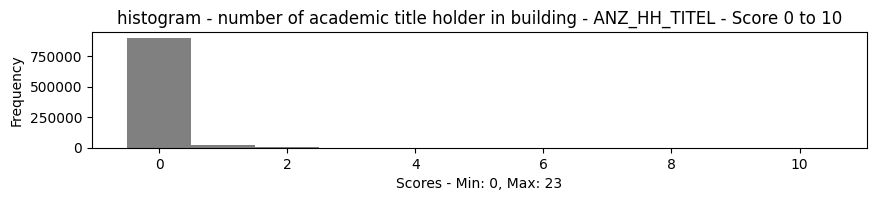

10 outliers (Score: %) 
 23: 0.0%, 20: 0.0%, 18: 0.0%, 17: 0.0%, 16: 0.0% … 5: 0.0%, 4: 0.0%, 3: 0.1%, 2: 0.3%, 1: 2.7%




In [56]:
'''
ANZ_HH_TITEL  
- No pre-processing needed: max values might be strange or extreme but are possible
'''

view_feature (datasets, feature_desc, 'ANZ_HH_TITEL', False)

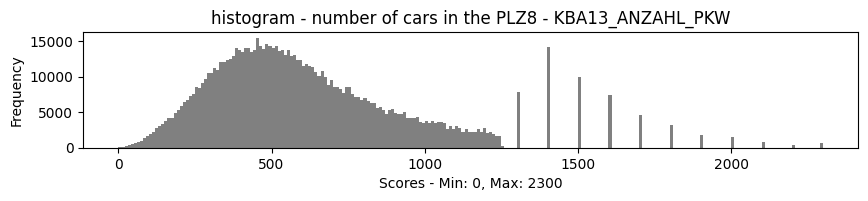

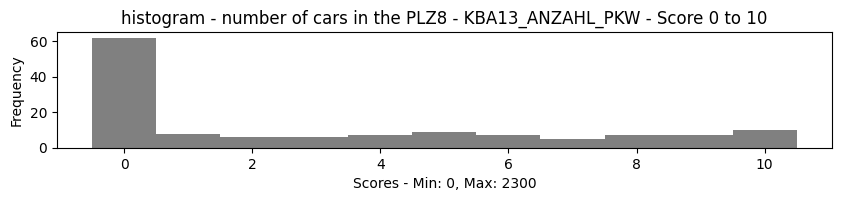

10 outliers (Score: %) 
 2300: 0.1%, 2200: 0.0%, 2100: 0.1%, 2000: 0.2%, 1900: 0.2% … 1800: 0.3%, 1700: 0.5%, 1600: 0.8%, 1500: 1.1%, 1400: 1.5%




In [57]:
'''
KBA13_ANZAHL_PKW
- in this feature values over 1250 is grouped by 100. 
  Log scaling is needed due to high skewness.
'''

view_feature (datasets, feature_desc, 'KBA13_ANZAHL_PKW')

In [58]:
p_process['3.1.1-KBA13_ANZAHL_PKW'] = 'log_scaling / KBA13_ANZAHL_PKW'

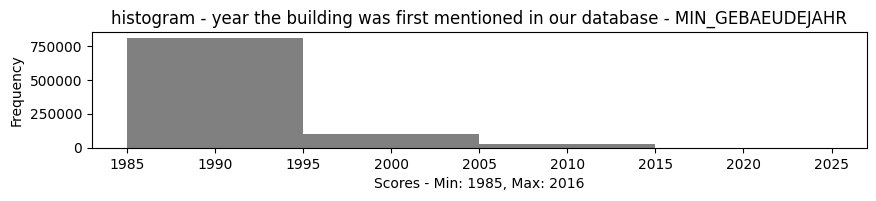

10 outliers (Score: %) 
 2016: 0.0%, 2015: 0.1%, 2014: 0.1%, 2013: 0.2%, 2012: 0.2% … 1989: 0.3%, 1988: 0.1%, 1987: 0.1%, 1986: 0.0%, 1985: 0.0%




In [59]:
'''
MIN_GEBAEUDEJAHR   
- No pre-processing needed
'''

view_feature (datasets, feature_desc, 'MIN_GEBAEUDEJAHR', True, False)

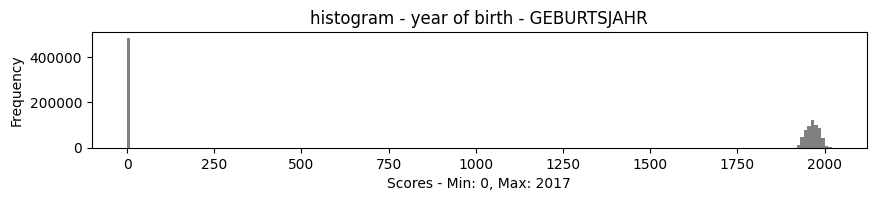

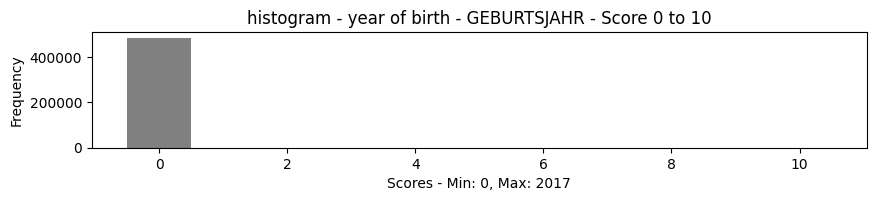

10 outliers (Score: %) 
  … 




In [60]:
'''
GEBURTSJAHR  
- outliers: birth year can not be 0 and anyone born before 1900 is extreme
  that Value < 1900 should be replaced to null
'''

view_feature (datasets, feature_desc, 'GEBURTSJAHR')

In [61]:
p_process['3.1.1-GEBURTSJAHR'] = 'np.where / GEBURTSJAHR / Score < 1900 to -1'

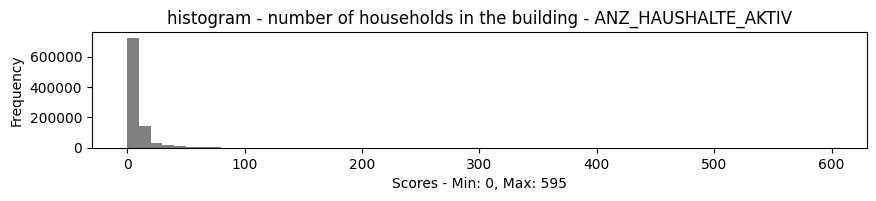

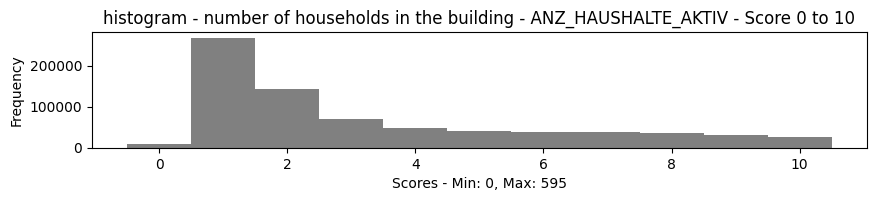

10 outliers (Score: %) 
 595: 0.0%, 536: 0.0%, 523: 0.0%, 515: 0.0%, 445: 0.0% … 26: 0.3%, 25: 0.3%, 24: 0.3%, 23: 0.4%, 22: 0.4%




In [62]:
'''
ANZ_HAUSHALTE_AKTIV  
- No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
- Log scaling is needed due to high skewness
'''

view_feature (datasets, feature_desc, 'ANZ_HAUSHALTE_AKTIV')

In [63]:
'''
NOTE
'''

p_process['3.1.1-ANZ_HAUSHALTE_AKTIV'] = 'log_scaling / ANZ_HAUSHALTE_AKTIV'

##### 3.1.2 object dataset Scores of intersection features

* 뭐뭐뭐

In [64]:
datasets_obj_score = dataset_summary(datasets, feature_desc, ['object'])

number of Attribute(s): 4


,Attribute,count,unique,top,freq,Desc,null_portion
0,CAMEO_INTL_2015,933466,43,51,83563,CAMEO classification 2015 - international typology,0.137973
1,CAMEO_DEU_2015,933466,45,6B,66306,CAMEO classification 2015 - detailled classification,0.137973
2,OST_WEST_KZ,939798,2,W,759910,flag indicating the former GDR/FRG,0.132125
3,CAMEO_DEUG_2015,933466,19,8,87739,CAMEO classification 2015 - Uppergroup,0.137973


In [65]:
'''
check if Scores in actual datasets are within range given by attr.
'''

# merge min/max values by Attribute in attr_num_score in 2.3.1
for i in datasets_obj_score.Attribute.unique():
    score_in_datasets = set(datasets[i].unique())
    score_in_ref_attr = set(ref_attr.query('Attribute == "{}"'.format(i)).Score.values)
    
    print (i)
    print (f'a) scores in datasets: {score_in_datasets}')
    print (f'b) scores in ref_attr: {score_in_ref_attr}')
    print (f'a) b) intersection: {score_in_datasets.intersection(score_in_ref_attr)}')
    print (f'a) - b): {score_in_datasets - score_in_ref_attr}')
    print (f'b) - a): {score_in_ref_attr - score_in_datasets}', '\n')

CAMEO_INTL_2015
a) scores in datasets: {nan, '55', '31', 12.0, 13.0, 14.0, 15.0, '51', '23', 22.0, 23.0, 24.0, 25.0, 31.0, 32.0, 33.0, 34.0, 35.0, '43', 41.0, 43.0, 44.0, 45.0, 51.0, 52.0, 54.0, 55.0, '24', '12', '33', '14', '45', '35', '13', 'XX', '25', '22', '15', '52', '34', '32', '41', '54', '44'}
b) scores in ref_attr: {11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55, -1}
a) b) intersection: {12, 13, 14, 15, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 43, 44, 45, 51, 52, 54, 55}
a) - b): {nan, '55', '31', '51', '23', '43', '12', '24', '33', '14', '45', '35', '13', 'XX', '25', '22', '15', '52', '34', '32', '41', '54', '44'}
b) - a): {42, 11, 53, 21, -1} 

CAMEO_DEU_2015
a) scores in datasets: {'1D', '4D', '7C', '8A', '9A', '4B', '9E', '1C', '2C', '6D', '7E', '4E', '8B', '9D', '6F', '2D', '6E', '3C', '7B', '5F', '5B', '6A', '1E', '5A', '6C', 'XX', '4A', '1A', '5C', '9C', nan, '1B', '8C', '8D', '7A', '2A', '5D', '3B', '7D', '4C', '3D', '

In [66]:
'''
피쳐 2개는 Score가 추치가 아니며 나머지 2개는 수치 Score를 string으로 기록한 경우가 있으며
'XX', 'X'로 null이 표기되어 있음
'''

none_numeric_in_datasets = ['CAMEO_DEU_2015', 'OST_WEST_KZ']

'''
NOTE
'''

p_process['3.1.2-CAMEO_INTL_2015XX'] = 'replace / CAMEO_INTL_2015 / {"XX": -1}'
p_process['3.1.2-CAMEO_DEU_2015'] = 'replace / CAMEO_DEU_2015 / {"XX": -1}'
p_process['3.1.2-CAMEO_DEUG_2015X'] = 'replace / CAMEO_DEUG_2015 / {"X": -1}'
p_process['3.1.2-dtype'] = 'astype / All features in numeric_discrete_features / change dtype to float'

#### 3.2 exclusive features NOT in reference files

In [67]:
'''
datasets_excl containing exclusive features of datasets
'''

datasets_excl = concat_data[
    list(feature_dict['in_customers_notin_ref_attr'])].copy()

##### 3.2.1 numeric dataset Scores of exclusive features

뭐뭐뭐

In [68]:
'''
excl_num_score containing Scores denoted in number
'''

datasets_excl_num_score = dataset_summary(datasets_excl, feature_desc, ['int', 'float'])

number of Attribute(s): 57


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
0,KBA13_ANTG4,925792.0,0.652691,0.724787,0.0,0.0,1.0,1.0,2.0,KBA13 ANTG4,0.145059,0 to 2
1,RT_UEBERGROESSE,987455.0,2.948525,1.492625,0.0,2.0,3.0,4.0,5.0,Rt overgrowth,0.088116,0 to 5
2,GEMEINDETYP,935123.0,24.275811,11.997949,11.0,12.0,22.0,30.0,50.0,Parish type,0.136443,11 to 50
3,MOBI_RASTER,939798.0,2.457470,1.546797,1.0,1.0,2.0,4.0,6.0,Mobi Raster,0.132125,1 to 6
4,ALTER_KIND2,34599.0,13.442412,3.244667,2.0,11.0,14.0,16.0,18.0,Old child2,0.968049,2 to 18


min_max Scores: 
 ['0 to 2' '0 to 5' '11 to 50' '1 to 6' '2 to 18' '1 to 9' '1 to 5'
 '1 to 10' '1 to 1_082_873' '0 to 1' '1 to 11' '7 to 18' '0 to 11'
 '1 to 13' '0 to 449' '0 to 4' '0 to 10' '0 to 25' '1 to 56' '4 to 18'
 '1_900 to 2_018' '0 to 45' '0 to 3' '1 to 3']


* **data type of features with wider min/max Score gap**
  
min/max Score gap is not big. 아무 reference가 없으니 section_2에서 정리한 일반 원칙 적용하여 pre-processing

All features that have min/max Score gap over 10 and null portion below 50% are to be checked below.

In [69]:
'''
check features that have min/max Score gap over 10
나머지 피쳐 중 드롭한 50% 이상 빈 피쳐를 제외하면 6개가 컨티뉴어스임 
'''
# from datasets_excl_num_score above, extract Attribute values having min/max Score gap over 10
continuous_in_datasets_excl_attribute = datasets_excl_num_score[
    (datasets_excl_num_score['max'] - datasets_excl_num_score['min']) > 10].Attribute.unique()

continuous_in_datasets_excl = datasets_excl_num_score.query(
    'Attribute in @continuous_in_datasets_excl_attribute and null_portion < 0.5')
view_all(continuous_in_datasets_excl)

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
2,GEMEINDETYP,935123.0,24.275811,11.997949,11.0,12.0,22.0,30.0,50.0,Parish type,0.136443,11 to 50
9,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,0.000000,1 to 1_082_873
15,ANZ_KINDER,962778.0,0.151364,0.501062,0.0,0.0,0.0,0.0,11.0,Anz children,0.110904,0 to 11
18,VK_DISTANZ,959085.0,7.087279,3.367266,1.0,4.0,7.0,10.0,13.0,VK distance,0.114314,1 to 13
20,ANZ_STATISTISCHE_HAUSHALTE,939798.0,7.162317,14.347487,0.0,1.0,3.0,8.0,449.0,Anz statistical households,0.132125,0 to 449
33,ALTERSKATEGORIE_FEIN,768084.0,13.087451,5.090172,0.0,10.0,14.0,17.0,25.0,Age category fine,0.290698,0 to 25
41,EINGEZOGENAM_HH_JAHR,962778.0,2003.044442,7.120764,1900.0,1997.0,2002.0,2009.0,2018.0,Intended HH year,0.110904,1_900 to 2_018
49,VERDICHTUNGSRAUM,935123.0,4.656614,8.595244,0.0,0.0,1.0,5.0,45.0,Compression room,0.136443,0 to 45


In [70]:
'''
디스크리트인 2개는 디스크립션을 보면 카테고리임
'''
continuous_in_datasets_excl = continuous_in_datasets_excl.query(
    'Attribute != "ALTERSKATEGORIE_FEIN" and Attribute != "GEMEINDETYP"')

In [71]:
'''
NOTE
LNR is the serial index of dataset 이므로 드롭함
'''

to_drop.append('LNR')

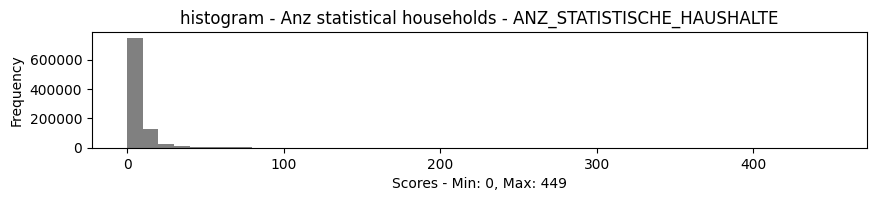

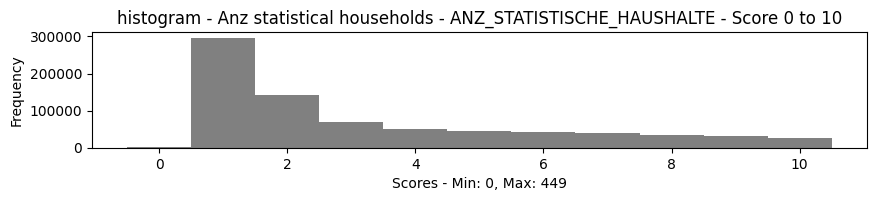

10 outliers (Score: %) 
 449: 0.0%, 445: 0.0%, 375: 0.0%, 371: 0.0%, 369: 0.0% … 23: 0.3%, 22: 0.4%, 21: 0.4%, 20: 0.4%, 19: 0.5%




In [72]:
'''
ANZ_STATISTISCHE_HAUSHALTE   
  - No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
  - Log scaling is needed due to high skewness
'''

view_feature (datasets_excl, feature_desc, 'ANZ_STATISTISCHE_HAUSHALTE')

In [73]:
'''
NOTE
'''

p_process['3.2.1-ANZ_STATISTISCHE_HAUSHALTE'] = 'log_scaling / ANZ_STATISTISCHE_HAUSHALTE'

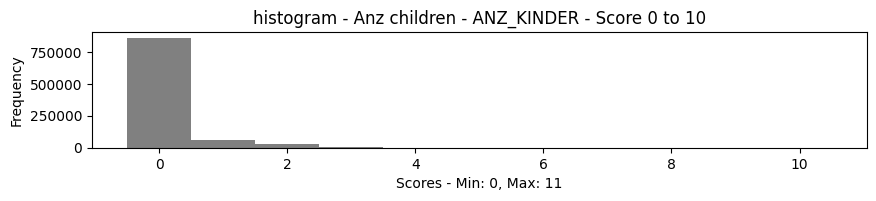

10 outliers (Score: %) 
 11: 0.0%, 9: 0.0%, 8: 0.0%, 7: 0.0%, 6: 0.0% … 5: 0.0%, 4: 0.1%, 3: 0.7%, 2: 3.0%, 1: 6.5%




In [74]:
'''
ANZ_KINDER  
  - 0이 매우 많기는 하나 정확한 뜻을 알 수 없으니 살림
'''

view_feature (datasets_excl, feature_desc, 'ANZ_KINDER', False, True)

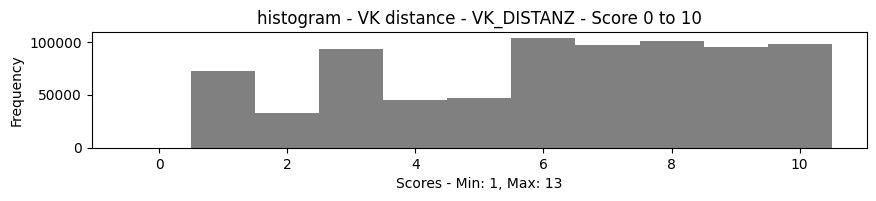

10 outliers (Score: %) 
  … 




In [75]:
'''
VK_DISTANZ  
- No pre-processing needed although Eng translation not completely understandable
'''

view_feature (datasets_excl, feature_desc, 'VK_DISTANZ', False, True)

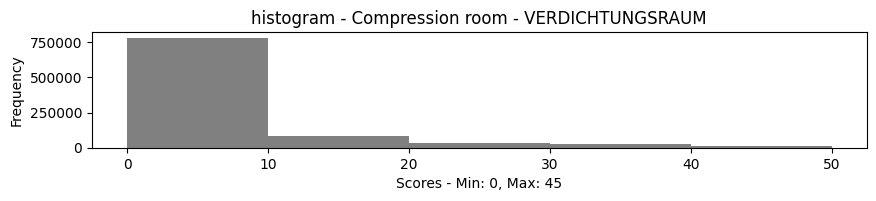

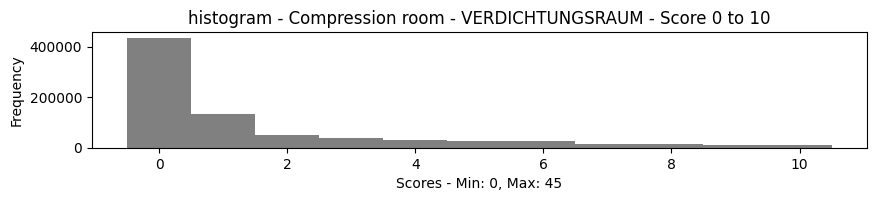

10 outliers (Score: %) 
 45: 0.2%, 44: 0.2%, 43: 0.2%, 42: 0.2%, 41: 0.1% … 17: 0.8%, 16: 0.8%, 15: 0.8%, 14: 0.9%, 13: 1.0%




In [76]:
'''
VERDICHTUNGSRAUM   
- No pre-processing needed although Eng translation not completely understandable
'''

view_feature (datasets_excl, feature_desc, 'VERDICHTUNGSRAUM')

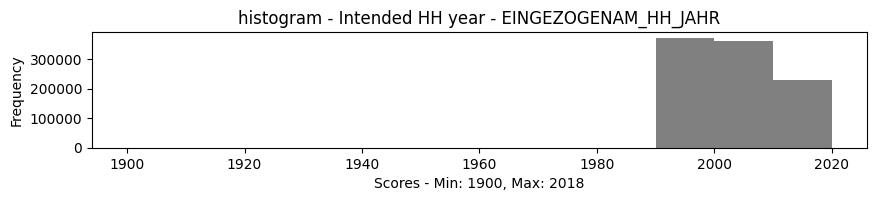

10 outliers (Score: %) 
 1971: 0.0%, 1904: 0.0%, 1900: 0.0% … 1971: 0.0%, 1904: 0.0%, 1900: 0.0%




In [77]:
'''
EINGEZOGENAM_HH_JAHR 
- outliers: Eng translation is not completely understandable, but 3 outliers can be replaced to null
'''

view_feature (datasets_excl, feature_desc, 'EINGEZOGENAM_HH_JAHR', True, False)

In [78]:
p_process['3.2.1-EINGEZOGENAM_HH_JAHR'] = 'np.where / EINGEZOGENAM_HH_JAHR / Score < 1980 to -1'

##### 3.2.2 object dataset Scores of exclusive features

///// For ....

In [79]:
'''
datasets_excl_obj_score containing Scores denoted in obj
'''

datasets_excl_obj_score = dataset_summary(datasets_excl, feature_desc, ['object'])

number of Attribute(s): 4


,Attribute,count,unique,top,freq,Desc,null_portion
0,PRODUCT_GROUP,191652,3,COSMETIC_AND_FOOD,100860,Product Group,0.823015
1,EINGEFUEGT_AM,939798,5254,1992-02-10 00:00:00,448482,Finded on,0.132125
2,D19_LETZTER_KAUF_BRANCHE,778063,35,D19_UNBEKANNT,227248,D19 Last purchase industry,0.281483
3,CUSTOMER_GROUP,191652,2,MULTI_BUYER,132238,Customer Group,0.823015


In [80]:
'''
4개 모두 디스크리트임
'''

none_numeric_in_datasets_excl = ['D19_LETZTER_KAUF_BRANCHE', 'CUSTOMER_GROUP', 'EINGEFUEGT_AM', 'PRODUCT_GROUP']

In [81]:
'''
NOTE
datetime으로 변환하데 년도만 남김 as there are too many unique values
'''

p_process['3.2.2-EINGEFUEGT_AM'] = 'astype / EINGEFUEGT_AM / change dtype to datetime only with year values'

In [82]:
'''
check if abnormal Scores exist in actual datasets.
으나 전처리 내용은 없음
'''
# 제외
datasets_excl_obj_score = datasets_excl_obj_score.query('Attribute != "EINGEFUEGT_AM"')

# 
for i in datasets_excl_obj_score.Attribute.unique():
    
    print (i)
    print (f'scores in datasets: {set(datasets_excl[i].unique())}', '\n')

PRODUCT_GROUP
scores in datasets: {nan, 'COSMETIC', 'FOOD', 'COSMETIC_AND_FOOD'} 

D19_LETZTER_KAUF_BRANCHE
scores in datasets: {'D19_SONSTIGE', 'D19_UNBEKANNT', 'D19_TIERARTIKEL', 'D19_BANKEN_GROSS', 'D19_BANKEN_DIREKT', 'D19_LEBENSMITTEL', 'D19_TELKO_REST', 'D19_SCHUHE', 'D19_VERSICHERUNGEN', 'D19_BANKEN_LOKAL', nan, 'D19_SAMMELARTIKEL', 'D19_RATGEBER', 'D19_HAUS_DEKO', 'D19_VERSAND_REST', 'D19_FREIZEIT', 'D19_KOSMETIK', 'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_ENERGIE', 'D19_KINDERARTIKEL', 'D19_BILDUNG', 'D19_HANDWERK', 'D19_BUCH_CD', 'D19_NAHRUNGSERGAENZUNG', 'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_DROGERIEARTIKEL', 'D19_BANKEN_REST', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_BIO_OEKO', 'D19_VOLLSORTIMENT', 'D19_BEKLEIDUNG_REST', 'D19_BEKLEIDUNG_GEH', 'D19_REISEN'} 

CUSTOMER_GROUP
scores in datasets: {nan, 'MULTI_BUYER', 'SINGLE_BUYER'} 



### 4. Pre-processing

* categorize pre-processing items

In [83]:
'''
create pre-processing items
'''
# transform p_process from dictionary to dataframe 
p_process_items = {'pre_processing_itmes' : p_process}
p_process_items = pd.DataFrame(p_process_items).reset_index()
p_process_items [['method', 'by_feature']] = p_process_items[
    'pre_processing_itmes'].str.split(' / ', n=1, expand=True)
p_process_items = p_process_items[['index', 'method', 'by_feature']].sort_values(['method', 'index'])

log_scaling_items = p_process_items.query('method == "log_scaling"')
table = pa.Table.from_pandas(log_scaling_items)
pq.write_table(table, 'log_scaling_items.parquet')

view_all(p_process_items)

,index,method,by_feature
16,3.1.2-dtype,astype,All features in numeric_discrete_features / change dtype to float
19,3.2.2-EINGEFUEGT_AM,astype,EINGEFUEGT_AM / change dtype to datetime only with year values
1,2.3.1-drop,drop,All / drop features in to_drop
4,3.1.1-ANZ_HAUSHALTE_AKTIV,log_scaling,ANZ_HAUSHALTE_AKTIV
8,3.1.1-KBA13_ANZAHL_PKW,log_scaling,KBA13_ANZAHL_PKW
17,3.2.1-ANZ_STATISTISCHE_HAUSHALTE,log_scaling,ANZ_STATISTISCHE_HAUSHALTE
0,2.3.1-1,mask,All / replace Score to null if corresponding Meaning is in to_null
3,2.3.1-unknown_9,mask,category_small in unknown_9 / Score 9 to -1
5,3.1.1-ANZ_PERSONEN,np.where,ANZ_PERSONEN / Score > 10 to -1
6,3.1.1-ANZ_TITEL,np.where,ANZ_TITEL / Score of ANZ_PERSONEN > 10 to -1


* create pre-processing reference

In [84]:
'''
replacements dictionary
'''
p_process_replace = p_process_items.query('method == "replace"').iloc[1:]
p_process_replace[['col', 'dict_val']] = p_process_replace[
    'by_feature'].str.split(' / ', expand=True)

# replacements = dict(zip(p_process_replace['col'], p_process_replace['dict_val']))
replacements = dict(map(lambda col, dict_val: (col, eval(dict_val)), 
                        p_process_replace['col'], p_process_replace['dict_val']))
replacements

{'LP_FAMILIE_FEIN': {0: -1},
 'LP_FAMILIE_GROB': {0: -1},
 'LP_LEBENSPHASE_FEIN': {0: -1},
 'LP_LEBENSPHASE_GROB': {0: -1},
 'CAMEO_DEUG_2015': {'X': -1},
 'CAMEO_DEU_2015': {'XX': -1},
 'CAMEO_INTL_2015': {'XX': -1}}

In [85]:
'''
mask to process Scores corresponding to Meaning in to_null
'''

mask_to_null = ref_attr.query('Meaning in (@to_null)')[['Attribute', 'Score']].set_index('Attribute')
mask_to_null = mask_to_null[mask_to_null.Score != -1]

features_unknown_9 = [i for i in feature_desc.Attribute.unique() if i.split('_')[0] in unknown_9]
mask_unknown_9 = pd.DataFrame(index = features_unknown_9, columns = ['Score'], data = 9)

In [86]:
'''feature categorization'''

# excl features of customers
customers_excl_discrete = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_excl_none_numeric = ['CUSTOMER_GROUP', 'PRODUCT_GROUP']
customers_excl_numeric = ['ONLINE_PURCHASE']

# continuous_features form 3.1.1 and 3.2.1
continuous_features = list(
    continuous_in_datasets.Attribute.unique()) + list(continuous_in_datasets_excl.Attribute.unique())

# discrete_features
discrete_features = list(
    x for x in feature_desc.Attribute.unique() if x not in continuous_features)
discrete_features = list(
    x for x in discrete_features if x not in customers_excl_discrete)

# none_numeric_discrete_features form 3.1.2 and 3.2.2
none_numeric_discrete_features = none_numeric_in_datasets + none_numeric_in_datasets_excl
none_numeric_discrete_features = list(
    x for x in none_numeric_discrete_features if x not in customers_excl_none_numeric)

# numeric_discrete_features
numeric_discrete_features = list(
    x for x in discrete_features if x not in none_numeric_discrete_features)

* pre-processing

In [87]:
def pre_processing (data):
    '''
    function to pre_process datasets
    '''        
    # mask
    mask = data.eq(mask_to_null['Score'], axis=1)
    data = data.mask(mask)
    
    mask = data.eq(mask_unknown_9['Score'], axis=1)
    data = data.mask(mask)

    # np.where
    data['ANZ_PERSONEN'] = np.where(data['ANZ_PERSONEN'] > 10, -1, data['ANZ_PERSONEN'])
    data['ANZ_TITEL'] = np.where(data['ANZ_PERSONEN'] > 10, -1, data['ANZ_TITEL'])
    data['GEBURTSJAHR'] = np.where(data['GEBURTSJAHR'] < 1900, -1, data['GEBURTSJAHR'])
    data['EINGEZOGENAM_HH_JAHR'] = np.where(data['EINGEZOGENAM_HH_JAHR'] < 1980, -1, data['EINGEZOGENAM_HH_JAHR'])

    # replacement
    data = data.replace(replacements)
    data = data.replace(-1, np.nan)

    # astype
    data[numeric_discrete_features] = data[numeric_discrete_features].astype(float)
    data['EINGEFUEGT_AM'] = pd.to_datetime(data['EINGEFUEGT_AM'], format = '%Y-%m-%d').dt.year 
    
    # drop
    data = data.drop(to_drop, axis = 1)

    return data

In [88]:
org_azdias = azdias.copy()
azdias = pre_processing (azdias)

In [89]:
org_customers = customers.copy()
customers = pre_processing (customers)
customers[customers_excl_numeric] = customers[customers_excl_numeric].astype(float)     

* drop columns with missing values over threshold

% of missing value in 361 columns of azdias
mean    11.696800
std     13.839740
min      0.000000
25%      0.544646
50%     11.871354
75%     13.073637
max     99.864792


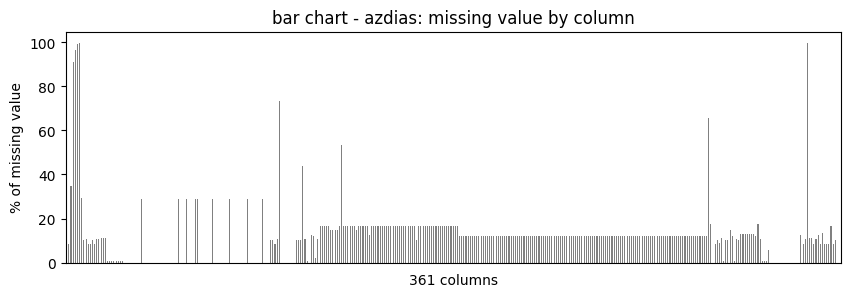

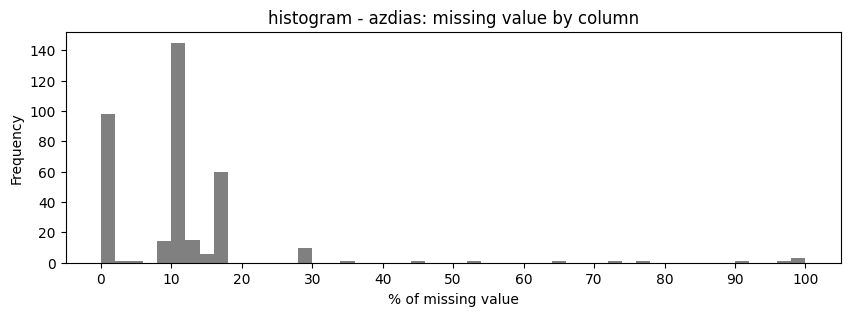

In [90]:
'''missing column overview: azdias'''

azdias.name = 'azdias'
miss_val_summary (azdias)

% of missing value in 364 columns of customers
mean    21.025218
std     15.660753
min      0.000000
25%      1.676476
50%     26.757352
75%     26.757352
max     99.876860


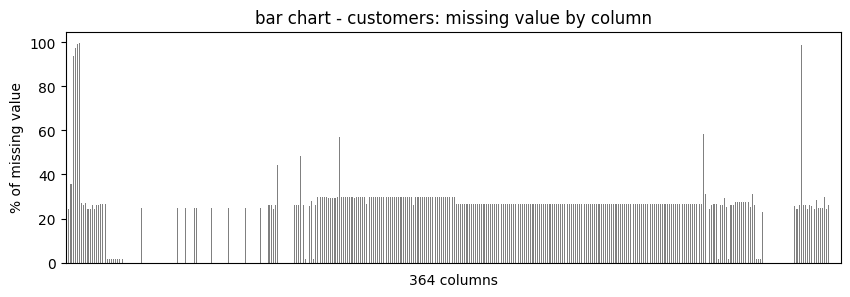

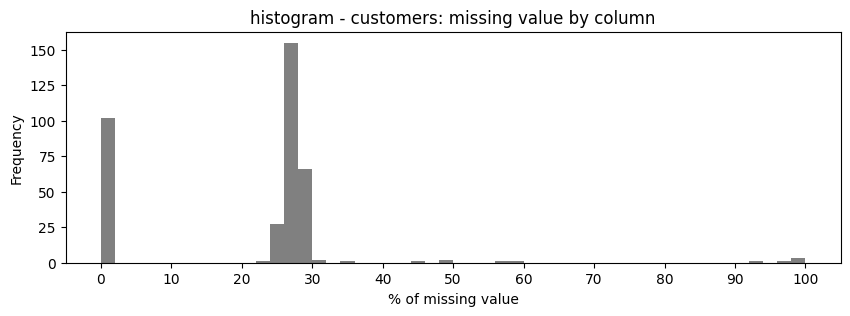

In [91]:
'''missing column overview: customers'''

customers.name = 'customers'
miss_val_summary (customers)

In [92]:
'''
columns of azdias with missing values over 33%
'''
temp_missing_col = azdias.isnull().mean()
azdias_missing_col = list(temp_missing_col[temp_missing_col > 0.33].index)
print ('azdias missing columns:', azdias_missing_col)

temp_missing_col = customers.isnull().mean()
customers_missing_col = list(temp_missing_col[temp_missing_col > 0.33].index)
print ('customers missing columns:', customers_missing_col)

azdias missing columns: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
customers missing columns: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [93]:
'''drop columns with missing values over 33%'''

azdias = azdias.drop(azdias_missing_col, axis = 1)
customers = customers.drop(customers_missing_col, axis = 1)

# add dropped columns to to_drop
to_drop.extend(customers_missing_col)

* modify feature categorization

In [94]:
log_scaling_items = pq.read_table('log_scaling_items.parquet').to_pandas()
log_scaling_items

,index,method,by_feature
4,3.1.1-ANZ_HAUSHALTE_AKTIV,log_scaling,ANZ_HAUSHALTE_AKTIV
8,3.1.1-KBA13_ANZAHL_PKW,log_scaling,KBA13_ANZAHL_PKW
17,3.2.1-ANZ_STATISTISCHE_HAUSHALTE,log_scaling,ANZ_STATISTISCHE_HAUSHALTE


In [95]:
log_scaling_features = list(log_scaling_items.by_feature.values)
continuous_features = [i for i in continuous_features if i not in (log_scaling_features)]

In [96]:
# modify and save lists as pickle
for i, j in zip(
    [customers_excl_discrete, customers_excl_none_numeric, customers_excl_numeric, 
     log_scaling_features, continuous_features, 
     discrete_features, none_numeric_discrete_features, numeric_discrete_features],
    ['customers_excl_discrete', 'customers_excl_none_numeric', 'customers_excl_numeric',
     'log_scaling_features', 'continuous_features',
     'discrete_features', 'none_numeric_discrete_features', 'numeric_discrete_features']):
    
    i = [x for x in i if x not in (to_drop)]
    pickle_list = pickle.dumps(i)
    with open(j + '.pkl', 'wb') as f:
        f.write(pickle_list)

* drop rows with missing values over threshold

% of missing value in 891221 rows of azdias
mean     9.682003
std     21.665365
min      0.000000
25%      0.000000
50%      0.285714
75%      2.857143
max     71.714286


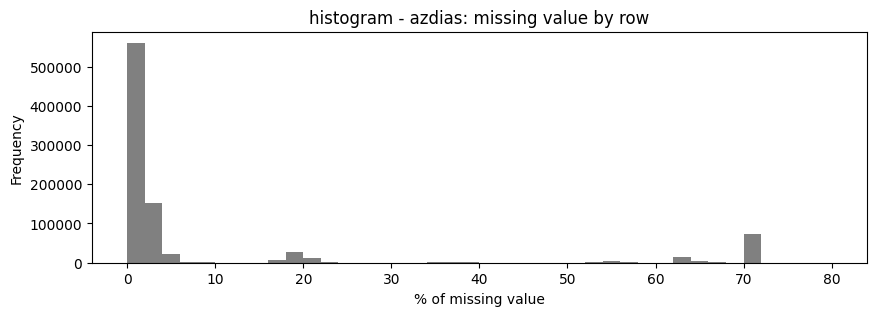

In [97]:
'''missing row overview: azdias'''

azdias.name = 'azdias'
miss_val_summary (azdias, axis_val = 'row', bar_chart = False)

% of missing value in 191652 rows of customers
mean    19.465858
std     30.702572
min      0.000000
25%      0.000000
50%      0.000000
75%     62.322946
max     71.104816


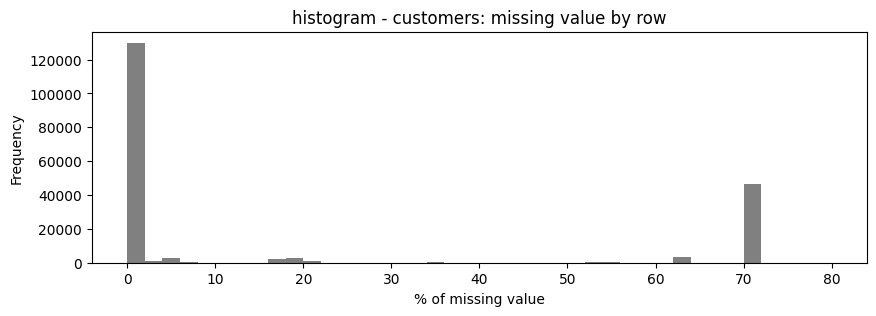

In [98]:
'''missing row overview: customers'''

customers.name = 'customers'
miss_val_summary (customers, axis_val = 'row', bar_chart = False)

In [99]:
'''drop columns with missing values over 33%'''

temp_missing_row = azdias.isnull().sum(axis = 1) / azdias.shape[1]
temp_missing_row = temp_missing_row > 0.33
azdias = azdias[~temp_missing_row]

temp_missing_row = customers.isnull().sum(axis = 1) / customers.shape[1]
temp_missing_row = temp_missing_row > 0.33
customers = customers[~temp_missing_row]

* save pre-processed files as parquet

In [100]:
table = pa.Table.from_pandas(azdias)
pq.write_table(table, 'azdias.parquet')

In [101]:
table = pa.Table.from_pandas(customers)
pq.write_table(table, 'customers.parquet')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

* load pre-processed datasets and feature category lists 

In [102]:
azdias = pq.read_table('azdias.parquet').to_pandas()
azdias.shape

(785421, 350)

In [103]:
customers = pq.read_table('customers.parquet').to_pandas()
customers.shape

(140400, 353)

In [104]:
'''load feature category lists'''
for i in [
    'customers_excl_discrete', 'customers_excl_none_numeric', 'customers_excl_numeric',
    'log_scaling_features', 'continuous_features',
    'discrete_features', 'none_numeric_discrete_features', 'numeric_discrete_features']:
    
    with open(i + '.pkl', 'rb') as f:
        pickle_list = f.read()

    globals()[i] = pickle.loads(pickle_list)

### 1. Dataset transformation

* transformation pipelines

In [105]:
'''log_scaling_features'''

log_scaling_pipeline = Pipeline([
    ('log_scaling', FunctionTransformer(np.log1p)),
    ('imputation', SimpleImputer(missing_values = np.nan, strategy = 'median')),
    ('standardization', StandardScaler())
])

In [106]:
'''continuous_features'''

continuous_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values = np.nan, strategy = 'median')),
    ('standardization', StandardScaler())
])

In [107]:
'''numeric_discrete_features'''

numeric_discrete_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ('standardization', StandardScaler())
])

In [108]:
'''customers_excl_numeric'''

customers_excl_numeric_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ('standardization', StandardScaler())
])

In [109]:
'''none_numeric_discrete_features'''

none_numeric_discrete_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ('one_hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))
])

In [110]:
'''customers_excl_none_numeric'''

customers_excl_none_numeric_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ('one_hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))
])

* dataset transformation

In [111]:
none_numeric_discrete_features

['CAMEO_DEU_2015', 'OST_WEST_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [114]:
'''azdias_tf'''

azdias_transformers = [('log_scaling', log_scaling_pipeline, log_scaling_features),
                      ('continuous', continuous_pipeline, continuous_features),
                      ('numeric_discrete', numeric_discrete_pipeline, numeric_discrete_features),
                      ('none_numeric_discrete', none_numeric_discrete_pipeline, none_numeric_discrete_features)]

azdias_col_transformer = ColumnTransformer(transformers = azdias_transformers)
azdias_tf = azdias_col_transformer.fit_transform(azdias)
azdias_tf.shape

In [116]:
'''customers_tf'''

customers_transformers = [('log_scaling', log_scaling_pipeline, log_scaling_features),
                          ('continuous', continuous_pipeline, continuous_features),
                          ('numeric_discrete', numeric_discrete_pipeline, numeric_discrete_features),
                          ('customers_excl_numeric', customers_excl_numeric_pipeline, customers_excl_numeric),
                          ('none_numeric_discrete', none_numeric_discrete_pipeline, none_numeric_discrete_features),
                          ('customers_excl_none_numeric', customers_excl_none_numeric_pipeline, customers_excl_none_numeric),                          
                          ]

customers_col_transformer = ColumnTransformer(transformers = customers_transformers)
customers_tf = customers_col_transformer.fit_transform(customers)
customers_tf.shape

### 2. PCA

In [127]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias_tf)

Number of principal components for 0.9 explained variance: 178


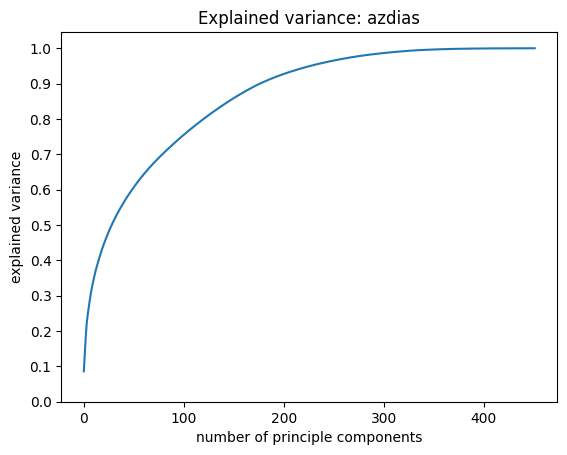

In [141]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance: azdias')
plt.xlabel('number of principle components')
plt.ylabel('explained variance')
plt.yticks(np.arange(0, 1.1, 0.1));

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print('Number of principal components for 0.9 explained variance:',
      np.argmax(cumulative_variance >= 0.9) + 1)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [113]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'

Work / Ref

In [ ]:
# def col_val (df):
#     '''
#     function to check values of dataframe columns
#     df : dataframe
#     '''
#     # for i in df.columns:
#     #     print (i, '-', df[i].nunique(), 'values', '\n',
#     #         df[i].value_counts(), '\n', '*     *     *')
#     for i in df.columns:
#         print (i, '-', df[i].nunique(), 'values', '\n',
#         list(df[i].unique()), '\n', '*     *     *')

In [ ]:
# # from googletrans import Translator

# # Create an instance of the Translator
# translator = Translator(service_urls=['translate.google.com'])

# # Text to be translated
# text = "AGER_TYP"

# # Translate the text from German to English
# translation = translator.translate(text, src='de', dest='en')

# # Print the translated text
# print("Original text (German):", text)
# print("Translated text (English):", translation.text)

In [ ]:
# def miss_val_hist(df, axis_val, x_bin = 10):
#     '''
#     function to display missing value histogram by column or raw
#     df: dataframe
#     axis_val: str, one of 'column' or 'row'
#     x_bin: size of xtick bin, 10 as default 
#     '''
#     # axis value
#     axis_num = 0 if axis_val == 'column' else 1
    
#     # % of missing values
#     missing_pct = df.isnull().mean(axis = axis_num) * 100

#     # max % of missing values by column
#     missing_pct_max = missing_pct.max()
#     print ('max % of missing values by ' + axis_val + ': ', missing_pct_max)

#     # plot missing values by column
    
#     print (missing_pct.describe())
    
#     x_range = ((missing_pct_max + x_bin * 2) // x_bin) * x_bin

#     ax = missing_pct.plot(
#         kind = 'hist', figsize=(10, 3), color='gray',
#         bins = np.arange(0, x_range, 10),
#         title = (df.name + ': missing value by ' + axis_val)
#         )
#     ax.set_xlabel('% of missing value');

In [ ]:
# 파이써닉 하지 못한 코드
# # missing value overview
# for i in range(0, ((azdias.shape[1] + 100) // 100) * 100, 100):
#     msno.matrix(azdias.iloc[:, i : i + 99],
#                 figsize=(10, 3), fontsize = 12, labels = False, sparkline = False)
#     plt.title('missing value overview: col ' + str (i) + ' to ' + str (min(i + 99, azdias.shape[1] - 1)),
#               fontsize = 12);

In [ ]:
# # % of columns with missing values of over 30%
# (azdias.isnull().mean() * 100 > 30).mean()

In [ ]:
# # % of columns with missing values of 25% to 30%
# ((azdias.isnull().mean() * 100 > 25) & (30 >= azdias.isnull().mean() * 100)).mean()

In [ ]:
# 아마도 쓰지 않을 plot
# plot = azdias_col_missing_pct.plot(
#     kind = 'bar', figsize=(10, 3), color='dimgray', xticks = [],
#     title = 'azdias_col_missing_pct',
#     xlabel = '366 columns',
#     ylabel = '% of missing values')

In [ ]:
# num_df = customers.select_dtypes(include=['float', 'int64']).iloc[:, 1:]
# num_df.head()

In [ ]:
# len(pd.unique(customers.select_dtypes(include='float').values.flatten()).tolist())

In [ ]:
# with pd.option_context(
#     'display.max_rows', None, 'display.max_colwidth', None):
#     display(pd.DataFrame(attr.apply(lambda x: x.unique())))

In [ ]:
# attr_not_null = ~(attr.Attribute.isna())
# attr.loc[attr_not_null, 'Description'] = attr.loc[
#     attr_not_null, 'Description'] + ' ' + attr.loc[attr_not_null, 'desc_shift']

# desc_to_null = (attr.Attribute.isna()) & ~(attr.Description.isna())
# attr.loc[desc_to_null, 'Description'] = np.nan
# attr = attr.drop(columns = 'desc_shift')
# attr.loc[attr_with_value.shift(-1, fill_value = True), 'Description']
# attr_shift = attr_null.shift
# attr[attr_null.shift, 'Description'] = attr.loc[
#     attr_null.shift(fill_value = False), 'Description'] + ' ' + attr[attr_null, 'Description']

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# info_mg = info_mg.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
# # attr_excl = attr[attr.Attribute.isin(attr_excl)].copy()
# attr_not_null = attr.dropna(subset = 'Attribute').copy()
# attr_not_null = attr_not_null.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# info_mg = pd.concat(
#     [info_mg, attr_not_null[['Attribute', 'Description']]],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# '''
# to 313 rows of Attribute in info, add 15 values exclusively in attr,
# and remove 52 values exclusively in information files
# '''

# info_mg = info.iloc[:, 1:].copy()
# attr_excl = attr[attr.Attribute.isin(attr_excl)][['Attribute', 'Description']].copy()

# info_mg = pd.concat(
#     [info_mg, attr_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# info_mg = info_mg.drop_duplicates(subset = ['Attribute', 'Description'])
# # info_mg = info_mg.sort_values(by = list(info_mg.columns), ascending=False)
# # # info_mg = info_mg.drop_duplicates(subset='Attribute')

# info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(info_mg.info())
# info_mg.head()

In [ ]:
# view_all(info_mg)

In [ ]:
# '''
# to 2258 rows of Attribute in attr, add 13 values exclusively in info,
# and remove 52 values exclusively in information files
# '''

# attr_mg = attr.copy()
# info_excl = info[info.Attribute.isin(info_excl)][['Attribute', 'Description']].copy()
# info_excl['Value'] = 'form info'
# info_excl['Meaning'] = 'form info'

# attr_mg = pd.concat(
#     [attr_mg, info_excl],
#     ignore_index  = True,
#     axis = 0
#     )
# # info_mg = info_mg.drop_duplicates()

# # info_mg = info_mg[~(info_mg.Attribute.isin(infofile_excl))]

# print(attr_mg.info())
# attr_mg.head()

In [ ]:
# attr_mg.tail(30)

In [ ]:
# '''
# there are 93 and 51 exclusive values in data and information files
# '''

# datafile_Attr = azdias_Attr.union(customers_Attr)
# infofile_Attr = info_Attr.union(attr_Attr)

# datafile_excl = datafile_Attr - infofile_Attr
# infofile_excl = infofile_Attr - datafile_Attr

# print (len(datafile_excl), 'Attribute value(s) exclusively in data files:',
#        '\n', datafile_excl)
# print (len(infofile_excl), 'Attribute value(s) exclusively in information files:',
#        '\n', infofile_excl)

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# info['Information level'] = info['Information level'].fillna(method = 'ffill')

# info.head()

In [ ]:
# 불필요 한 것으로 보임
# '''
# fill null cells as only 1st lines of information have values
# '''

# attr[['Attribute', 'Description']] = attr[
#     ['Attribute', 'Description']].fillna(method = 'ffill')

# attr.head(10)

In [ ]:
# '''
# To enhance readability of data set - over 100 features are without description -   
# I added 14 Description values from attr, and made a column of translation   
# (ger_to_eng) to df_feature using code below.
# However as this code-running takes somewhat long time, I saved the dataframe processed
# as df_feature.xlsx in root folder
# '''

# # For values of Attribute without Description, add 14 Description values from attr
# df_feature.set_index('Attribute', inplace = True)

# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# df_feature.update(attr_excl)

# df_feature.reset_index(inplace = True)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# df_feature['ger_to_eng'] = np.where(
#     df_feature.Description.isnull(),
#     df_feature.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# df_feature['Desc'] = df_feature.Description.fillna('') + df_feature.ger_to_eng.fillna('')

# # # sort by Attribute and Information level
# # df_feature.sort_values(by = ['Attribute', 'Information level'], inplace= True)

# # df_feature = pd.read_excel('df_feature.xlsx', index_col = [0])
# # df_feature.head(10)

In [ ]:
# attr_excl = attr[attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# df_feature.Description = df_feature.Description.mask(
#     df_feature.Attribute == attr_excl.Attribute,
#     attr_excl.Description
#     )
# print ('Attributes missing Description:', df_feature[df_feature.Description.isna()].shape[0])
# print (df_feature.shape)
# df_feature.head()

# ValueError: Can only compare identically-labeled Series objects

In [ ]:
# feature_desc.set_index('Attribute', inplace = True)

# attr_Attr = set(attr.Attribute.dropna().unique())
# info_Attr = set(info.Attribute.dropna().unique())
# attr_excl = attr[
#     attr.Attribute.isin(attr_Attr - info_Attr)][['Attribute', 'Description']].copy()
# attr_excl.set_index('Attribute', inplace = True)
# feature_desc.update(attr_excl)

# feature_desc.reset_index(inplace = True)

In [ ]:
# '''
# alignment of features between data files: 
# df customers has 3 more exclusive columns
# '''

# azdias_Attr = set(azdias.columns)
# customers_Attr = set(customers.columns)

# print(azdias_Attr - customers_Attr)
# print(customers_Attr - azdias_Attr)

In [ ]:
# '''
# alignment of features between information files
# '''
# info_Attr = set(info.Attribute.dropna().unique())
# attr_Attr = set(attr.Attribute.dropna().unique())

# # info_excl = info_Attr - attr_Attr
# # attr_excl = attr_Attr - info_Attr

# print (len(info_Attr - attr_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - attr_Attr)
# print (len(attr_Attr - info_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - info_Attr)
# '''
# alignment of features between customers and information files
# '''
# print ('Attribute between customers and info')
# print (len(customers_Attr - info_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - info_Attr)
# print (len(info_Attr - customers_Attr), 'Attribute value(s) exclusively in info:',
#        '\n', info_Attr - customers_Attr)
# print ('In', len(info_Attr), 'features of info,', 
#        len(info_Attr) - len(info_Attr - customers_Attr), 'features are in Attribute of customers', '\n')

# print ('Attribute between customers and attr')
# print (len(customers_Attr - attr_Attr), 'feature(s) exclusively in customers:',
#        '\n', customers_Attr - attr_Attr)
# print (len(attr_Attr - customers_Attr), 'Attribute value(s) exclusively in attr:',
#        '\n', attr_Attr - customers_Attr)
# print ('In', len(attr_Attr), 'features of attr,',
#        len(attr_Attr) - len(attr_Attr - customers_Attr), 'features are in Attribute of customers')

In [ ]:
# list(feature_dict.keys())[0]
# feature_dict.values()

In [ ]:
# values = np.array([1, 2, 3, 4])

# subtractions = np.subtract.outer(values, values)[np.triu_indices(len(values), k=1)]

# for result in subtractions:
#     print(result)

In [ ]:
# for i, (k, v) in enumerate(feature_dict.items()):
#     for j in range(i + 1, 4):
#             result = values[i] - values[j]
#             print(f"{values[i]} - {values[j]} = {result}")
#     print (i, k, v)
    
# for i, (k, v) in enumerate(zip(list(feature_dict.keys()), list(feature_dict.values()))):
#     print (i, (k, v))

In [ ]:
# '''
# customers에는 없고 attr에만 있는 42개 Attribute는 Desc가 없으으로
# (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# print ('customers에는 없고 attr에만 있는 42개 Attribute 수:', 
#        attr_num[attr_num.Desc.isna() == True].Attribute.nunique(),
#        '\n')

# attr_num = attr_num[attr_num.Desc.isna() == False]
# print (attr_num.info())

In [ ]:
# '''
# str data of column Value
# '''
# # attr_num with only numeric values in Value
# attr_str = attr[attr['Value_dtype'] == str].copy()
# print (attr_str.shape) 

# # add Desc and Information level
# attr_str = vlookup(attr_str, feature_desc, 'Attribute', ['Desc', 'Additional notes'])
# print (attr_str.info())
# attr_str.head()

In [ ]:
# '''
# 3개 null attribute는 정수와 문자를 모두 값을로 갖는 것들로 42개는 유효하고
# 이 42개는 다음 section에서 볼 예정이므로 (1.5 alignment) desc가 null이 아닌 행만 keep
# '''

# # attr_str[attr_str.Desc.isna() == True] # int와 str을 모두 갖는 셀. 따라서 42는 맞음.... 이 별로 중요하지도 않은 것을 남겨야 하나...

# attr_str = attr_str[attr_str.Desc.isna() == False]
# print (attr_str.info())

In [ ]:
# # attr_str_to_check = pv_attr_str[pv_attr_str.Meaning.str.contains('numeric value')].Attribute
# attr_str_to_check = pv_attr_str[
#     pv_attr_str.index.get_level_values(2).str.contains('numeric value')].index.get_level_values(0)
# # 먼저 추후 체크할 것들을 뽑아 놓고
# attr_str_to_check

In [ ]:
# pv_attr_str = pd.DataFrame(pv_attr_str[
#     ~(pv_attr_str.index.get_level_values(0).isin(attr_str_to_check))
#     &~(pv_attr_str.index.get_level_values(2) == 'unknown')
#     ].to_records())

# pv_attr_str = pd.pivot_table(
#     pv_attr_str,
#     index = ['Attribute', 'Desc'],
#     values = 'Value',
#     aggfunc = lambda x: list(x)
#     )

# view_all(pv_attr_str)

In [ ]:
# print(not_in_attr_str.values.T.shape)
# not_in_attr_str.values.T.tolist()

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + bin_interval, bin_interval)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 5.0
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 5.0 * iqr
#     upper_threshold = q3 + 5.0 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(set([i for i in col_val if i < lower_threshold or i > upper_threshold]), reverse = True)
#     for j in outliers:
#         print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
#     print ('\n', '==========' * 10)

In [ ]:
# for i in concat_cont_ft[1:]:

#     min_val = cc_num[i].min()
#     max_val = cc_num[i].max()
#     # bin_interval = 1
#     bin_edges = np.arange(min_val, max_val + 10, 10)

#     desc_val = concat_num[concat_num['Attribute'] == i]['Desc'].values[0]
#     count_val = int(concat_num[concat_num['Attribute'] == i].fillna(0)['count'].values[0])

#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = bin_edges,
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' ' + i)
#         );
#     ax.set_xlabel('Values: Min: ' + str(int(min_val)) + ', Max: ' + str(int(max_val)));
#     plt.show()
    
#     ax = cc_num[i].plot(
#         kind = 'hist',
#         figsize=(10, 1.5),
#         color='gray',
#         bins = np.arange(-0.5, 11.5, 1),
#         align = 'mid',
#         title = ('histogram - ' + desc_val + ' - Value 0 to 10')
#         );
#     ax.set_xlabel('Values');
#     plt.show()
    
#     # Define the outlier thresholds by applying multiplier 1.5
#     q1 = concat_num[concat_num['Attribute'] == i]['25%'].values[0]
#     q3 = concat_num[concat_num['Attribute'] == i]['75%'].values[0]
#     iqr = q3 - q1
#     lower_threshold = q1 - 1.5 * iqr
#     upper_threshold = q3 + 1.5 * iqr

#     # Identify outliers
#     col_val = cc_num[i].values
#     outliers = sorted(
#         set([i for i in col_val if i < lower_threshold or i > upper_threshold]),
#         reverse = True)
#     # for j in outliers:
#     #     print (int(j), '{:.1%}'.format(((cc_num[i] == j).sum())/count_val*100), end = ' ')
        
#     outlier_list = [str(int(j)) + ': ' + '{:.1%}'.format((cc_num[i] == j).sum() / count_val)
#                     for j in outliers]
    
#     print('Outliers (Value: %)')
#     for j in range(0, len(outlier_list), 10):
#         print (', '.join(outlier_list[j: j+10]))
#     print ('\n')

**[function]** score_meaning_val

In [ ]:
# def score_meaning_val(data, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
#     '''
#     function to check unique values of Score and Meaning by Attribute
#     data : dataframe to examine
#     pv_idx: list of pivot_table index
#     '''
#     data = vlookup(data, feature_desc, 'Attribute', ['Desc', 'Additional notes'], nan_val = 'no_info')
#     pv = pd.pivot_table(
#         data,
#         index = pv_idx,
#         values = ['Meaning', 'Score'],
#         aggfunc = lambda x: list(x))
    
#     return pv

In [ ]:
# def verify_null(data, null_list, pv_idx = ['Attribute', 'Description', 'Desc', 'Additional notes']):
#     '''
#     function to display the summary of Score and Meaning values,
#     when Meaning values are in the list containing possibly null values.   
    
#     data: dataframe to examine
#     null_list: list of possibly null values
#     pv_idx: pivot_table index
#     '''
#     null_check_Attribute = data[data['Meaning'].isin(null_list)]['Attribute'].to_list()
#     null_check = data[data['Attribute'].isin(null_check_Attribute)]
    
#     null_check = vlookup(null_check, feature_desc, 'Attribute', ['Desc', 'Additional notes'], fill_na = 'no_info')
#     pv = pd.pivot_table(
#         null_check,
#         index = pv_idx,
#         values = ['Score', 'Meaning'],
#         aggfunc = lambda x: list(x))
    
#     return pv

In [ ]:
# # For values of Attribute without Description, add 12 Description values from attr
# attr_to_add = attr[['Attribute', 'Description']].copy()
# attr_to_add.dropna(inplace = True)
# attr_to_add = attr_to_add.rename(columns = {'Description': 'Description_to_add'})

# feature_desc = vlookup(feature_desc, attr_to_add, 'Attribute')
# feature_desc.Description = np.where(
#     ((feature_desc.Description.isnull() == True) & (feature_desc.Description_to_add.isnull() == False)),
#     feature_desc.Description_to_add,
#     feature_desc.Description)
# feature_desc = feature_desc.drop('Description_to_add', axis=1)

# # For values of Attribute without Description, make colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# feature_desc['ger_to_eng'] = np.where(
#     feature_desc.Description.isnull(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.ger_to_eng.fillna('')

# feature_desc.info()

In [ ]:
# # pv_min_max 2.3.1 변경 for merge
# min_max_copy = pd.DataFrame(pv_min_max.to_records())
# min_max_copy.columns = list(
#     min_max_copy.columns[:2]) + list(eval(i)[0] for i in min_max_copy.columns[2:])
# min_max_copy

In [ ]:
# import pandas as pd
# import numpy as np
# from IPython.display import display
# import sys
# from contextlib import ExitStack

# def view_all (data):
#     '''
#     function to display all contents of data
#     '''
#     # with ExitStack() as stack:
#     #     stack.enter_context(pd.option_context(
#     #     'display.max_rows', None,
#     #     'display.max_colwidth', None,
#     #     'display.max_seq_items', None
#     #     ))
#     #     stack.enter_context(np.printoptions(threshold=np.inf))
    
#     # np.set_printoptions(threshold = sys.maxsize)
    
#     with pd.option_context(
#     'display.max_rows', None, 
#     'display.max_colwidth', None,
#     'display.max_seq_items', None,
#     ):
#         display(data)

In [ ]:
# '''
# categorize pre-processing items
# '''
# # # categorize p_process_items
# # p_process_all = p_process_items.query('by_feature.str.contains("All")')
# # p_process_items = p_process_items.query('not by_feature.str.contains("All")')

# # p_process_list = ['p_process_all']
# p_process_list = []
# for i in p_process_items.method.unique():
#     globals()['p_process_' + i] = p_process_items.query('method == "{}"'.format(i))
#     globals()['p_process_' + i].name = 'p_process_' + i
#     p_process_list.append('p_process_' + i)

# p_process_list

In [ ]:
# correlation_matrix = customers.corr(numeric_only = True)
# correlation_matrix

### eod